# Setup

In this part we import our packages, load our data and prepare it for further analysis.

In [1]:
import os
import time
import random
import glob
import warnings
from datetime import datetime

from PIL import Image
from skimage.color import rgb2gray

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from tqdm.auto import tqdm

import torch
import torch.nn.functional as F
from torch import nn
import copy

import tensorflow as tf
from keras import models
from keras import layers
from keras import losses
from keras import optimizers
from keras import Input
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from sklearn.decomposition import NMF, TruncatedSVD, PCA

from hmmlearn.hmm import GaussianHMM
from sklearn.utils import check_random_state
from sklearn import decomposition

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the data

Original data:
1. training: 9999 spectrograms , (1999 of type 0, 2000 of other types)
2. testing: 21890 spectrograms, (Type 0: 18116, Type 1: 556, Type 2: 1448, Type 3: 162, Type 4: 1608)

Transformed data:
1. Training set: 5040 Spectrograms (Type 0: 1008, Type 1: 1008, Type 2: 1008, Type 3: 1008, Type 4: 1008)
2. Validation set: 1896 Spectrograms (Type 0: 504, Type 1: 300, Type 2: 504, Type 3: 84, Type 4: 504)
3. Testing set: 1822 Spectrograms (Type 0: 496, Type 1: 256, Type 2: 488, Type 3: 78, Type 4: 504)

In [2]:
x_train = np.concatenate((np.load('x_train_0.npy'), np.load('x_train_1.npy'), np.load('x_train_2.npy'), np.load('x_train_3.npy'), np.load('x_train_4.npy')))
x_val = np.concatenate((np.load('x_val_0.npy'), np.load('x_val_1.npy'), np.load('x_val_2.npy'), np.load('x_val_3.npy'), np.load('x_val_4.npy')))
x_test = np.concatenate((np.load('x_test_0.npy'), np.load('x_test_1.npy'), np.load('x_test_2.npy'), np.load('x_test_3.npy'), np.load('x_test_4.npy')))

y_train = np.concatenate((np.zeros((1008)), np.zeros((1008))+1, np.zeros((1008))+2, np.zeros((1008))+3, np.zeros((1008))+4))
y_val = np.concatenate((np.zeros((504)), np.zeros((300))+1, np.zeros((504))+2, np.zeros((84))+3, np.zeros((504))+4))
y_test = np.concatenate((np.zeros((496)), np.zeros((256))+1, np.zeros((488))+2, np.zeros((78))+3, np.zeros((504))+4))

r = 308
c = 465
n1 = 5040
n2 = 1896
n3 = 1822

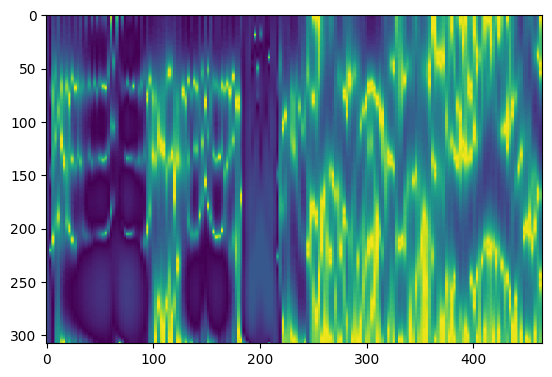

In [3]:
plt.imshow(x_train[0])

## Color Conversion

<Figure size 640x480 with 0 Axes>

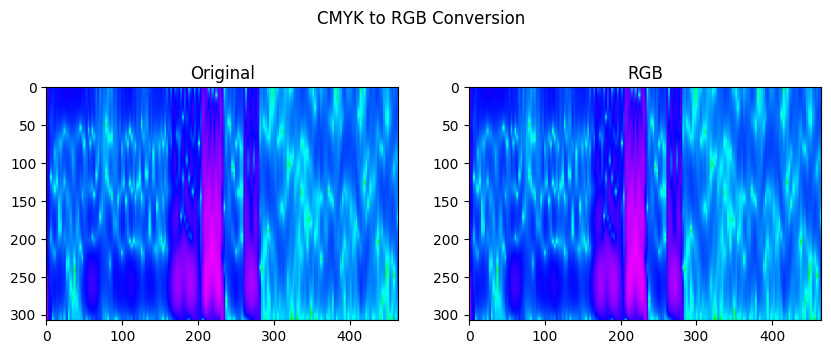

In [2]:
image = Image.open('MITBIH_20_Test/1.png')
image_rgb = image.convert("RGB")
# convert image to numpy array
data = np.asarray(image)
data_rgb = np.asarray(image_rgb)

plt.figure()
f, axarr = plt.subplots(1,2)
f.suptitle('CMYK to RGB Conversion')
f.set_size_inches(10, 4)
axarr[0].imshow(data)
axarr[0].set_title('Original')
axarr[1].imshow(data_rgb)
axarr[1].set_title('RGB')
plt.show()

<Figure size 640x480 with 0 Axes>

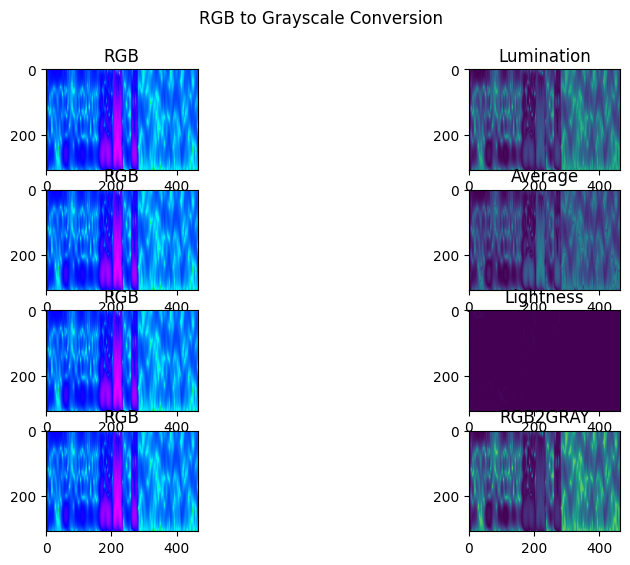

In [3]:
data = data_rgb

luminosity_constant = [0.299,0.587,0.114]
data_lumin = np.dot(data[...,:3], luminosity_constant).astype(np.uint8)

data_avg = np.sum(data,axis=-1,keepdims=1)/3
data_avg.reshape(308, 465)

data_light = np.max(data,axis=-1,keepdims=1)/2 + np.min(data,axis=-1,keepdims=1)/2
data_light.reshape(308, 465)

plt.figure()
f, axarr = plt.subplots(4,2)
f.suptitle('RGB to Grayscale Conversion')
f.set_size_inches(10, 6)
axarr[0,0].imshow(data)
axarr[0,0].set_title('RGB')
axarr[1,0].imshow(data)
axarr[1,0].set_title('RGB')
axarr[2,0].imshow(data)
axarr[2,0].set_title('RGB')
axarr[3,0].imshow(data)
axarr[3,0].set_title('RGB')
axarr[0,1].imshow(data_lumin)
axarr[0,1].set_title('Lumination')
axarr[1,1].imshow(data_avg)
axarr[1,1].set_title('Average')
axarr[2,1].imshow(data_light)
axarr[2,1].set_title('Lightness')
axarr[3,1].imshow(rgb2gray(data))
axarr[3,1].set_title('RGB2GRAY')
plt.show()

## Original data loading

In [ ]:
folder = 'x_val_4'
file_paths = glob.glob(os.path.join(folder, '*.png'))
x_val_4 = np.array([rgb2gray(np.asarray(Image.open(f).convert("RGB"))) for f in file_paths])
np.save('x_val_4', x_val_4)

## Data visualization

In [13]:
pca = PCA(n_components=2)
pca.fit(x_train.reshape(n1, r*c))
x_train_pca = pca.transform(x_train.reshape(n1, r*c))
print(x_train_pca.shape)

(5040, 2)


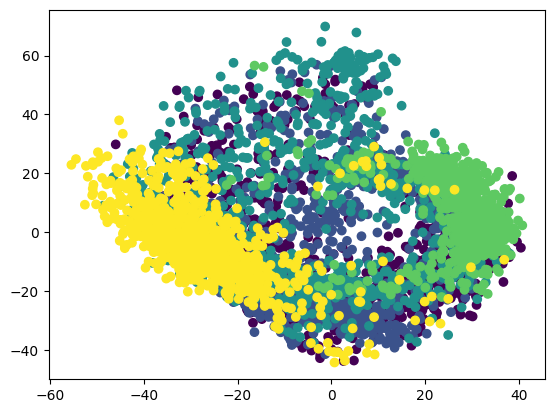

In [16]:
plt.scatter(x_train_pca[:,0], x_train_pca[:,1],c=y_train)
plt.show()

In [4]:
pca = PCA(n_components=3)
pca.fit(x_train.reshape(n1, r*c))
x_train_pca = pca.transform(x_train.reshape(n1, r*c))
print(x_train_pca.shape)

(5040, 3)


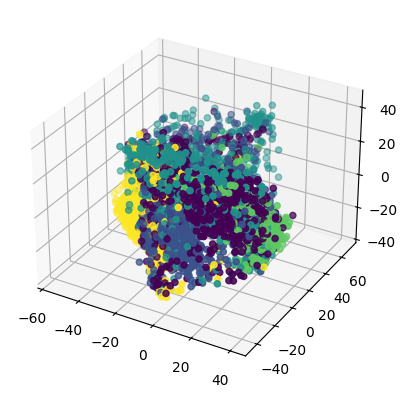

In [5]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x_train_pca[:,0], x_train_pca[:,1], x_train_pca[:,2], c=y_train)
plt.show()

# Embeddings

In this part we prepare all of our embeddings and test them on a simple spectrogram.

## PCA+LR

### Embedding functions

In [3]:
def embed_pca1(x):
    embed = np.empty((x.shape[0], r))
    for i in range(x.shape[0]):
        pca = PCA(n_components=1)
        pca.fit(x[i])
        embed[i] = pca.transform(x[i]).reshape(r)
    return embed

def embed_pca2(x):
    embed = np.empty((x.shape[0], r*2))
    for i in range(x.shape[0]):
        pca = PCA(n_components=2)
        pca.fit(x[i])
        embed[i] = pca.transform(x[i]).reshape(r*2)
    return embed

def matrix_form(X, n):
    return np.array([[x**i for i in range(0, n+1)] for x in X])


def least_squares(X, Y, n):
    X_mat = matrix_form(X, n)
    return np.linalg.inv(X_mat.T @ X_mat) @ X_mat.T @ Y

def embed_lr(x):
    embed = np.empty((x.shape[0], 2))
    X = np.arange(r)
    X_mat = matrix_form(X, 1)
    for i in range(x.shape[0]):
        pca = PCA(n_components=1)
        pca.fit(x[i])  
        embed[i] = (np.linalg.inv(X_mat.T @ X_mat) @ X_mat.T @ pca.transform(x[i])).reshape(2)
    return embed

In [4]:
start_time = time.time()
x_embed_pca1 = embed_pca1(x_train)
print("\t\t Embedding took %s seconds " % round((time.time() - start_time),5))

		 Embedding took 361.23709 seconds 


In [5]:
x_embed_pca1.shape

(5040, 308)

In [ ]:
start_time = time.time()
x_embed_pca2 = embed_pca2(x_train)
print("\t\t Embedding took %s seconds " % round((time.time() - start_time),5))

In [8]:
x_embed_pca2.shape

(5040, 616)

In [9]:
start_time = time.time()
x_embed_lr = embed_lr(x_train)
print("\t\t Embedding took %s seconds " % round((time.time() - start_time),5))

		 Embedding took 142.92451 seconds 


In [10]:
x_embed_lr.shape

(5040, 2)

### A single spectrogram

In [74]:
img = x_train[2000]
pca = PCA(n_components=1)
pca.fit(img)
img_pca = pca.transform(img)
print(img_pca.shape)

(308, 1)


In [75]:
img_recon = pca.inverse_transform(img_pca)
print(img_recon.shape)

(308, 465)


<Figure size 640x480 with 0 Axes>

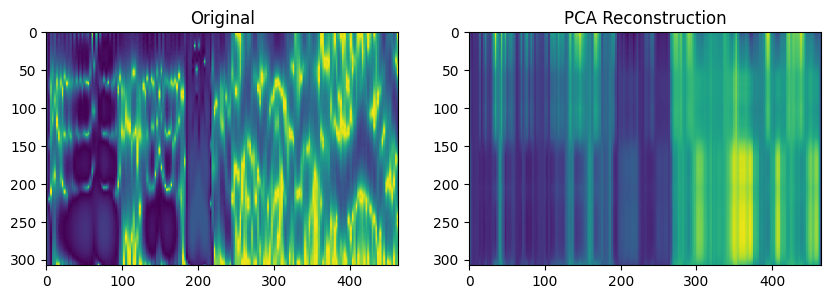

In [76]:
plt.figure()
f, axarr = plt.subplots(1,2)
f.set_size_inches(10, 4)
axarr[0].imshow(x_train[0])
axarr[0].set_title('Original')
axarr[1].imshow(img_recon)
axarr[1].set_title('PCA Reconstruction')
plt.show()

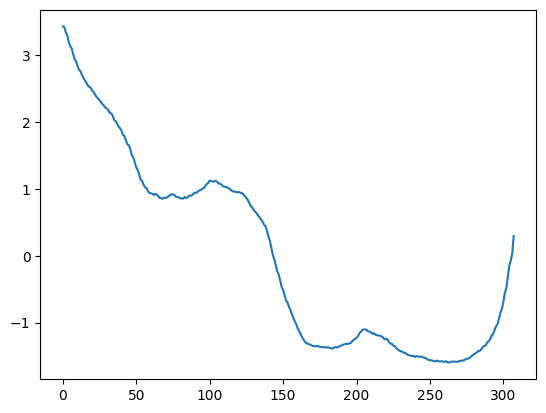

In [77]:
plt.plot(np.arange(308), img_pca)
plt.show()

In [78]:
def matrix_form(X, n):
    return np.array([[x**i for i in range(0, n+1)] for x in X])


def least_squares(X, Y, n):
    X_mat = matrix_form(X, n)
    return np.linalg.inv(X_mat.T @ X_mat) @ X_mat.T @ Y

In [97]:
X = np.arange(308)
n = 4
X_mat = matrix_form(X, n)

a = least_squares(X, img_pca, n)

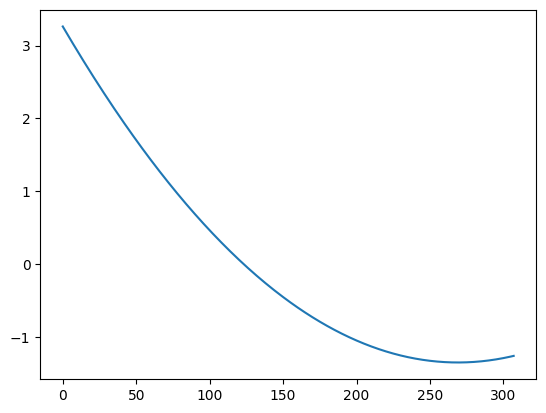

In [98]:
plt.plot(np.arange(308), (a.T @ X_mat.T).reshape(308))
plt.show()

In [99]:
best_n = 1
se = np.inf
l = []
X = np.arange(308)
for n in range(1,100):
    X_mat = matrix_form(X, n)
    a = least_squares(X, img_pca, n)
    if np.sum(((a.T @ X_mat.T).reshape(308) - img_pca)**2) < se:
        se = np.sum(((a.T @ X_mat.T).reshape(308) - img_pca)**2)
        best_n = n
    l.append(np.sum(((a.T @ X_mat.T).reshape(308) - img_pca)**2))

In [100]:
best_n

1

## AutoEncoder

In [ ]:
results = {i:1 for i in range(50)}
params = {i:1 for i in range(50)}

for i in range(50):
    lr = random.uniform(0.001, 0.15)
    m = random.uniform(0.85, 0.95)
    d = random.uniform(0.001, 0.15)
    params[i] = [lr,m,d]

    encoder = Sequential([
        Input(shape=(r*c,)),
        Dense(2000,   activation='relu'),
        Dense(1000,   activation='relu'),
        Dense(500,   activation='relu'),
        Dense(308,   activation='relu')
    ])

    decoder = Sequential([
        Input(shape=(308,)),
        Dense(500,  activation='relu'),
        Dense(1000,  activation='relu'),
        Dense(2000,   activation='relu'),
        Dense(r*c,  activation='sigmoid')
    ])

    img = Input(shape = (r*c,))
    latent_vector = encoder(img)
    output = decoder(latent_vector)
    model = Model(inputs = img, outputs = output)
    model.compile(optimizer = optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True, weight_decay=0.01), loss = 'binary_crossentropy')
    results[i] = model.evaluate(x_val, x_val)[0]

In [10]:
encoder = Sequential([
    Input(shape=(r*c,)),
    Dense(2000,   activation='relu'),
    Dense(1000,   activation='relu'),
    Dense(500,   activation='relu'),
    Dense(308,   activation='relu')
])

decoder = Sequential([
    Input(shape=(308,)),
    Dense(500,  activation='relu'),
    Dense(1000,  activation='relu'),
    Dense(2000,   activation='relu'),
    Dense(r*c,  activation='sigmoid')
])

img = Input(shape = (r*c,))
latent_vector = encoder(img)
output = decoder(latent_vector)
model = Model(inputs = img, outputs = output)
model.compile(optimizer = optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True, weight_decay=0.01), loss = 'binary_crossentropy')

model.fit(x_train.reshape(n1, c*r), x_train.reshape(n1, c*r), batch_size=100, epochs=20, verbose=1, 
          validation_data=(x_val.reshape(n2, c*r), x_val.reshape(n2, c*r)))
time_elapsed = datetime.now() - start_time

In [11]:
model.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 143220)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 308)            │   289,097,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 143220)         │   289,240,720 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 578,338,528 (2.15 GB)

 Trainable params: 578,338,528 (2.15 GB)

 Non-trainable params: 0 (0.00 B)

In [13]:
start_time = datetime.now()
model.fit(x_train.reshape(n1, c*r), x_train.reshape(n1, c*r), batch_size=100, epochs=20, verbose=1, 
          validation_data=(x_val.reshape(n2, c*r), x_val.reshape(n2, c*r)))
model.save('autoencoder.keras')
#model = keras.models.load_model('autoencoder.keras')
time_elapsed = datetime.now() - start_time
print('TRAINING TIME (hh:mm:ss.ms) {}'.format(time_elapsed))

MemoryError: Unable to allocate 2.69 GiB for an array with shape (5040, 143220) and data type float32

In [94]:
x_embed_ae = encoder(x_train.reshape(n1, c*r))

In [95]:
x_embed_ae.shape

TensorShape([5040, 308])

In [96]:
x_recon = decoder(x_embed_ae)

<Figure size 640x480 with 0 Axes>

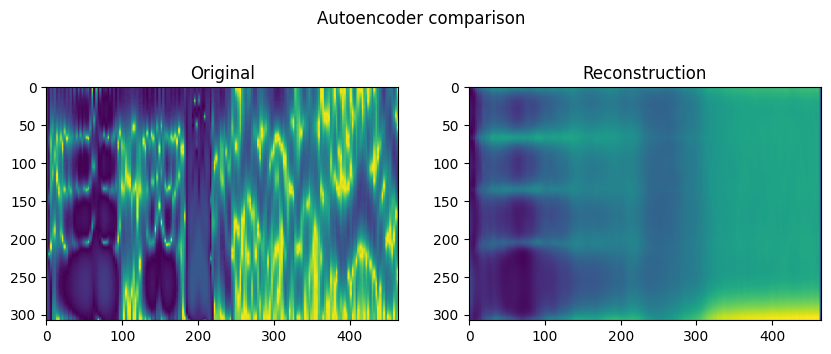

In [97]:
tf.experimental.numpy.experimental_enable_numpy_behavior()
plt.figure()
f, axarr = plt.subplots(1,2)
f.suptitle('Autoencoder comparison')
f.set_size_inches(10, 4)
axarr[0].imshow(x_train[0])
axarr[0].set_title('Original')
axarr[1].imshow(x_recon[0].reshape(r,c))
axarr[1].set_title('Reconstruction')
plt.show()

## NMF

### Embedding function

In [57]:
def embed_nmf1(x):
    embed = np.empty((x.shape[0], r))
    for i in range(x.shape[0]):
        model = NMF(n_components=1, init='random', random_state=0)
        W = model.fit_transform(x[i])
        embed[i] = W.flatten()
    return embed

def embed_nmf2(x):
    embed = np.empty((x.shape[0], c))
    for i in range(x.shape[0]):
        model = NMF(n_components=1, init='random', random_state=0)
        W = model.fit_transform(x[i])
        H = model.components_
        embed[i] = H.flatten()
    return embed

def embed_nmf3(x):
    embed = np.empty((x.shape[0], r + c))
    for i in range(x.shape[0]):
        model = NMF(n_components=1, init='random', random_state=0)
        W = model.fit_transform(x[i])
        H = model.components_
        embed[i] = np.concatenate((W.flatten(), H.flatten()))
    return embed

In [58]:
start_time = time.time()
x_embed_nmf1 = embed_nmf1(x_train)
print("\t\t Embedding took %s seconds " % round((time.time() - start_time),5))

		 Embedding took 18.93957 seconds 


In [5]:
x_embed_nmf1.shape

(5040, 308)

In [59]:
start_time = time.time()
x_embed_nmf2 = embed_nmf2(x_train)
print("\t\t Embedding took %s seconds " % round((time.time() - start_time),5))

		 Embedding took 8.82409 seconds 


In [7]:
x_embed_nmf2.shape

(5040, 465)

In [60]:
start_time = time.time()
x_embed_nmf3 = embed_nmf3(x_train)
print("\t\t Embedding took %s seconds " % round((time.time() - start_time),5))

		 Embedding took 8.45751 seconds 


In [9]:
x_embed_nmf3.shape

(5040, 773)

### A single spectrogram

In [54]:
model = NMF(n_components=1, init='random', random_state=0)
W = model.fit_transform(x_train[0])
H = model.components_

In [57]:
W.shape

(308, 1)

In [58]:
H.shape

(1, 465)

In [ ]:
plt.figure()
f, axarr = plt.subplots(1,2)
f.set_size_inches(10, 4)
axarr[0].imshow(x_train[0])
axarr[0].set_title('Original')
axarr[1].imshow(W@H)
axarr[1].set_title('NMF Reconstruction')
plt.show()

## SVD

### Embedding function

In [8]:
def embed_svd1(x):
    embed = np.empty((x.shape[0], 2))
    for i in range(x.shape[0]):
        model = TruncatedSVD(n_components=2, random_state=42)
        model.fit(x[i])
        embed[i] = model.singular_values_
    return embed

def embed_svd2(x):
    embed = np.empty((x.shape[0], 100))
    for i in range(x.shape[0]):
        model = TruncatedSVD(n_components=100, random_state=42)
        model.fit(x[i])
        embed[i] = model.singular_values_
    return embed

def embed_svd3(x):
    embed = np.empty((x.shape[0], c))
    for i in range(x.shape[0]):
        model = TruncatedSVD(n_components=1, random_state=42)
        model.fit(x[i])
        Sigma2 = np.diag(model.singular_values_)
        V = model.components_
        H = np.dot(Sigma2, V)
        embed[i] = H.flatten()
    return embed

def embed_svd4(x):
    embed = np.empty((x.shape[0], c+r))
    for i in range(x.shape[0]):
        model = TruncatedSVD(n_components=1, random_state=42)
        model.fit(x[i])
        Sigma2 = np.diag(model.singular_values_)
        U = model.transform(x[i])/model.singular_values_
        V = model.components_
        H = np.dot(Sigma2, V)
        embed[i] = np.concatenate((U.flatten(), H.flatten()))
    return embed

In [4]:
start_time = time.time()
x_embed_svd1 = embed_svd1(x_train)
print("\t\t Embedding took %s seconds " % round((time.time() - start_time),5))

		 Embedding took 21.94847 seconds 


In [12]:
x_embed_svd1.shape

(5040, 2)

In [5]:
start_time = time.time()
x_embed_svd2 = embed_svd2(x_train)
print("\t\t Embedding took %s seconds " % round((time.time() - start_time),5))

		 Embedding took 207.65048 seconds 


In [6]:
x_embed_svd2.shape

(5040, 100)

In [7]:
start_time = time.time()
x_embed_svd3 = embed_svd3(x_train)
print("\t\t Embedding took %s seconds " % round((time.time() - start_time),5))

		 Embedding took 13.03672 seconds 


In [16]:
x_embed_svd3.shape

(5040, 465)

In [9]:
start_time = time.time()
x_embed_svd4 = embed_svd4(x_train)
print("\t\t Embedding took %s seconds " % round((time.time() - start_time),5))

		 Embedding took 34.11931 seconds 


In [10]:
x_embed_svd4.shape

(5040, 773)

### A single spectrogram

In [17]:
model = TruncatedSVD(n_components=1, random_state=42)
model.fit(x_train[0])
Sigma2 = np.diag(model.singular_values_)
U = model.transform(x_train[0])/model.singular_values_
V = model.components_
H = np.dot(Sigma2, V)

In [18]:
Sigma2.shape

(1, 1)

In [19]:
Sigma2

array([[150.63394604]])

In [20]:
V.shape

(1, 465)

In [21]:
U.shape

(308, 1)

In [22]:
H.shape

(1, 465)

<Figure size 640x480 with 0 Axes>

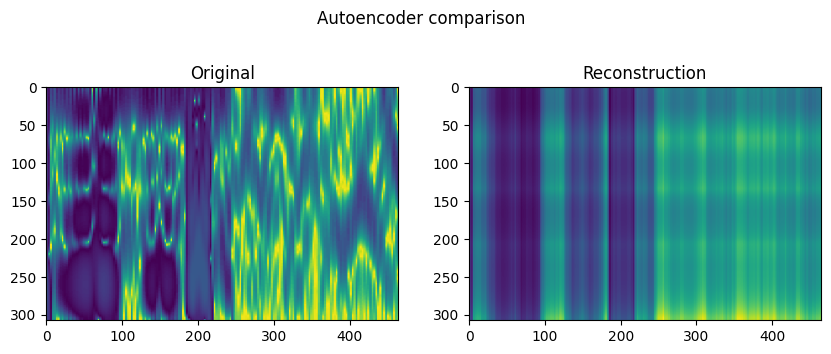

In [23]:
plt.figure()
f, axarr = plt.subplots(1,2)
f.suptitle('SVD reconstruction')
f.set_size_inches(10, 4)
axarr[0].imshow(x_train[0])
axarr[0].set_title('Original')
axarr[1].imshow(U@H)
axarr[1].set_title('Reconstruction')
plt.show()

# Classification

In this part we classify all of our data sets with different embeddings and tools.

## Basic MLP

Firstly, we use a basic MLP for a classification task. We train our model on the training set with the help of our validation set and finally test it on the testing set. We do that for all of our embeddings.

### PCA Embeddings experiments

In [3]:
# we need to use one hot encoding:
y_train_one_hot_enc = to_categorical(y_train)
y_val_one_hot_enc = to_categorical(y_val)
y_test_one_hot_enc = to_categorical(y_test)

In [12]:
x_embed_pca1_val = embed_pca1(x_val)
x_embed_pca2_val = embed_pca2(x_val)
x_embed_lr_val = embed_lr(x_val)

PCA1

In [78]:
#lr = random.uniform(0.001, 0.15)
#m = random.uniform(0.85, 0.95)
#d = random.uniform(0.001, 0.15)

model = Sequential()
model.add(Dense(5000, input_shape=(308,), activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, weight_decay=0.01), 
              metrics=['accuracy'])
start_time = time.time()
model.fit(x_embed_pca1, y_train_one_hot_enc, epochs=20, batch_size=100, validation_data=(x_embed_pca1_val, y_val_one_hot_enc))
print("\t\t took %s seconds " % round((time.time() - start_time),5))

Epoch 1/20


c:\Users\macka\OneDrive\Pulpit\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 286ms/step - accuracy: 0.3714 - loss: 1.4369 - val_accuracy: 0.4420 - val_loss: 1.2628
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 276ms/step - accuracy: 0.4857 - loss: 1.2621 - val_accuracy: 0.4341 - val_loss: 1.2920
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 283ms/step - accuracy: 0.4891 - loss: 1.2473 - val_accuracy: 0.4599 - val_loss: 1.2700
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 282ms/step - accuracy: 0.5124 - loss: 1.2135 - val_accuracy: 0.4631 - val_loss: 1.2361
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 281ms/step - accuracy: 0.5249 - loss: 1.1797 - val_accuracy: 0.4451 - val_loss: 1.3237
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 283ms/step - accuracy: 0.5239 - loss: 1.1781 - val_accuracy: 0.4620 - val_loss: 1.2489
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 286ms/step - accuracy: 0.5253 - loss: 1.1579 - val_accuracy: 0.4763 - val_loss: 1.2549
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 284ms/step - accuracy: 0.5375 - loss: 1.1537 - val_accuracy: 0.438

In [79]:
model.evaluate(x_embed_pca1_val, y_val_one_hot_enc)

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4768 - loss: 1.1834


[1.255713701248169, 0.4831223487854004]

In [80]:
x_embed_pca1_test = embed_pca1(x_test)
model.evaluate(x_embed_pca1_test, y_test_one_hot_enc)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5035 - loss: 1.1571


[1.2159490585327148, 0.5104281306266785]

PCA2

In [81]:
#lr = random.uniform(0.001, 0.15)
#m = random.uniform(0.85, 0.95)
#d = random.uniform(0.001, 0.15)

model = Sequential()
model.add(Dense(5000, input_shape=(616,), activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, weight_decay=0.01), 
              metrics=['accuracy'])
start_time = time.time()
model.fit(x_embed_pca2, y_train_one_hot_enc, epochs=20, batch_size=100, validation_data=(x_embed_pca2_val, y_val_one_hot_enc))
print("\t\t took %s seconds " % round((time.time() - start_time),5))

Epoch 1/20


c:\Users\macka\OneDrive\Pulpit\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 288ms/step - accuracy: 0.3743 - loss: 1.4517 - val_accuracy: 0.3940 - val_loss: 1.3531
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 291ms/step - accuracy: 0.4905 - loss: 1.2539 - val_accuracy: 0.4272 - val_loss: 1.3256
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 285ms/step - accuracy: 0.5161 - loss: 1.1965 - val_accuracy: 0.4615 - val_loss: 1.2621
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 285ms/step - accuracy: 0.5350 - loss: 1.1633 - val_accuracy: 0.4594 - val_loss: 1.2683
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 285ms/step - accuracy: 0.5535 - loss: 1.1188 - val_accuracy: 0.4393 - val_loss: 1.3299
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 286ms/step - accuracy: 0.5796 - loss: 1.0806 - val_accuracy: 0.4747 - val_loss: 1.2497
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 285ms/step - accuracy: 0.5823 - loss: 1.0624 - val_accuracy: 0.4863 - val_loss: 1.1978
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 286ms/step - accuracy: 0.5935 - loss: 1.0150 - val_accuracy: 0.484

In [82]:
model.evaluate(x_embed_pca2_val, y_val_one_hot_enc)

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3714 - loss: 1.7152


[1.43972647190094, 0.4778481125831604]

In [83]:
x_embed_pca2_test = embed_pca2(x_test)
model.evaluate(x_embed_pca2_test, y_test_one_hot_enc)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3823 - loss: 1.7706


[1.4372345209121704, 0.49396267533302307]

LR

In [75]:
#lr = random.uniform(0.001, 0.15)
#m = random.uniform(0.85, 0.95)
#d = random.uniform(0.001, 0.15)

model = Sequential()
model.add(Dense(5000, input_shape=(2,), activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, weight_decay=0.01), 
              metrics=['accuracy'])
start_time = time.time()
model.fit(x_embed_lr, y_train_one_hot_enc, epochs=20, batch_size=100, validation_data=(x_embed_lr_val, y_val_one_hot_enc))
print("\t\t took %s seconds " % round((time.time() - start_time),5))

Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 283ms/step - accuracy: 0.2134 - loss: 1.6084 - val_accuracy: 0.2199 - val_loss: 1.6121
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 289ms/step - accuracy: 0.2460 - loss: 1.5993 - val_accuracy: 0.2136 - val_loss: 1.6029
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 283ms/step - accuracy: 0.2717 - loss: 1.5906 - val_accuracy: 0.3064 - val_loss: 1.5893
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 299ms/step - accuracy: 0.2464 - loss: 1.5842 - val_accuracy: 0.2774 - val_loss: 1.5843
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 298ms/step - accuracy: 0.2630 - loss: 1.5685 - val_accuracy: 0.2331 - val_loss: 1.5825
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 300ms/step - accuracy: 0.2655 - loss: 1.5606 - val_accuracy: 0.2352 - val_loss: 1.5599
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 284ms/step - accuracy: 0.2695 - loss: 1.5617 - val_accuracy: 0.2025 - val_loss: 1.5755
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 283ms/step - accuracy: 0.2695 - loss: 1.5552 - val_accu

In [76]:
model.evaluate(x_embed_lr_val, y_val_one_hot_enc)

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2050 - loss: 1.5491


[1.546926498413086, 0.2779535949230194]

In [77]:
x_embed_lr_test = embed_lr(x_test)
model.evaluate(x_embed_lr_test, y_test_one_hot_enc)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2346 - loss: 1.5300


[1.5332765579223633, 0.29527992010116577]

### AutoEncoder experiments

In [98]:
# we need to use one hot encoding:
y_train_one_hot_enc = to_categorical(y_train)
y_val_one_hot_enc = to_categorical(y_val)
y_test_one_hot_enc = to_categorical(y_test)

In [99]:
x_embed_ae_val = encoder(x_val.reshape(n2, r*c))

In [100]:
#lr = random.uniform(0.001, 0.15)
#m = random.uniform(0.85, 0.95)
#d = random.uniform(0.001, 0.15)

model = Sequential()
model.add(Dense(5000, input_shape=(308,), activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, weight_decay=0.01), 
              metrics=['accuracy'])
start_time = time.time()
model.fit(x_embed_ae, y_train_one_hot_enc, epochs=20, batch_size=100, validation_data=(x_embed_ae_val, y_val_one_hot_enc))
print("\t\t took %s seconds " % round((time.time() - start_time),5))

c:\Users\macka\OneDrive\Pulpit\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 273ms/step - accuracy: 0.2010 - loss: 3.1933 - val_accuracy: 0.2848 - val_loss: 1.5921
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 267ms/step - accuracy: 0.2178 - loss: 1.6035 - val_accuracy: 0.3470 - val_loss: 1.5668
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 272ms/step - accuracy: 0.2477 - loss: 1.5974 - val_accuracy: 0.3064 - val_loss: 1.5878
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 279ms/step - accuracy: 0.2458 - loss: 1.5902 - val_accuracy: 0.3476 - val_loss: 1.5844
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 279ms/step - accuracy: 0.2707 - loss: 1.5824 - val_accuracy: 0.4193 - val_loss: 1.5709
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 279ms/step - accuracy: 0.2709 - loss: 1.5788 - val_accuracy: 0.3555 - val_loss: 1.5612
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 279ms/step - accuracy: 0.2831 - loss: 1.5674 - val_accuracy: 0.2147 - val_loss: 1.5795
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 279ms/step - accuracy: 0.2882 - loss: 1.5630 - val_accu

In [101]:
model.evaluate(x_embed_ae_val, y_val_one_hot_enc)

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0789 - loss: 1.6378


[1.5694661140441895, 0.30590716004371643]

In [103]:
x_embed_ae_test = encoder(x_test.reshape(n3, r*c))
model.evaluate(x_embed_ae_test, y_test_one_hot_enc)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0871 - loss: 1.6363


[1.5610848665237427, 0.32381996512413025]

### NMF Embeddings experiments

In [17]:
# we need to use one hot encoding:
y_train_one_hot_enc = to_categorical(y_train)
y_val_one_hot_enc = to_categorical(y_val)
y_test_one_hot_enc = to_categorical(y_test)

In [18]:
x_embed_nmf1_val = embed_nmf1(x_val)
x_embed_nmf2_val = embed_nmf2(x_val)
x_embed_nmf3_val = embed_nmf3(x_val)

NMF1

In [19]:
#lr = random.uniform(0.001, 0.15)
#m = random.uniform(0.85, 0.95)
#d = random.uniform(0.001, 0.15)

model = Sequential()
model.add(Dense(5000, input_shape=(r,), activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, weight_decay=0.01), 
              metrics=['accuracy'])
start_time = time.time()
model.fit(x_embed_nmf1, y_train_one_hot_enc, epochs=20, batch_size=100, validation_data=(x_embed_nmf1_val, y_val_one_hot_enc))
print("\t\t took %s seconds " % round((time.time() - start_time),5))

c:\Users\macka\OneDrive\Pulpit\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 294ms/step - accuracy: 0.2278 - loss: 1.6034 - val_accuracy: 0.1714 - val_loss: 1.5955
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 300ms/step - accuracy: 0.3249 - loss: 1.5556 - val_accuracy: 0.3149 - val_loss: 1.5152
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 303ms/step - accuracy: 0.3537 - loss: 1.4947 - val_accuracy: 0.3344 - val_loss: 1.4945
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 311ms/step - accuracy: 0.3722 - loss: 1.4549 - val_accuracy: 0.2769 - val_loss: 1.5792
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 304ms/step - accuracy: 0.4095 - loss: 1.4148 - val_accuracy: 0.3022 - val_loss: 1.4938
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 307ms/step - accuracy: 0.4248 - loss: 1.3969 - val_accuracy: 0.3354 - val_loss: 1.4384
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 290ms/step - accuracy: 0.4116 - loss: 1.3962 - val_accuracy: 0.3703 - val_loss: 1.4096
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 315ms/step - accuracy: 0.4164 - loss: 1.3806 - val_accu

In [20]:
model.evaluate(x_embed_nmf1_val, y_val_one_hot_enc)

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2171 - loss: 1.5810


[1.3220430612564087, 0.40770041942596436]

In [21]:
x_embed_nmf1_test = embed_nmf1(x_test)
model.evaluate(x_embed_nmf1_test, y_test_one_hot_enc)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2208 - loss: 1.5559


[1.2818602323532104, 0.4204171299934387]

NMF2

In [22]:
#lr = random.uniform(0.001, 0.15)
#m = random.uniform(0.85, 0.95)
#d = random.uniform(0.001, 0.15)

model = Sequential()
model.add(Dense(5000, input_shape=(c,), activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, weight_decay=0.01), 
              metrics=['accuracy'])
start_time = time.time()
model.fit(x_embed_nmf2, y_train_one_hot_enc, epochs=20, batch_size=100, validation_data=(x_embed_nmf2_val, y_val_one_hot_enc))
print("\t\t took %s seconds " % round((time.time() - start_time),5))

c:\Users\macka\OneDrive\Pulpit\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 302ms/step - accuracy: 0.4803 - loss: 1.3103 - val_accuracy: 0.6893 - val_loss: 0.8744
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 282ms/step - accuracy: 0.7256 - loss: 0.7694 - val_accuracy: 0.7247 - val_loss: 0.7165
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 292ms/step - accuracy: 0.7648 - loss: 0.6444 - val_accuracy: 0.8249 - val_loss: 0.5216
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 298ms/step - accuracy: 0.7539 - loss: 0.7164 - val_accuracy: 0.7321 - val_loss: 0.8017
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 291ms/step - accuracy: 0.7592 - loss: 0.6933 - val_accuracy: 0.7753 - val_loss: 0.6110
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 306ms/step - accuracy: 0.6551 - loss: 1.0482 - val_accuracy: 0.6735 - val_loss: 0.9273
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 305ms/step - accuracy: 0.7969 - loss: 0.5926 - val_accuracy: 0.8254 - val_loss: 0.5300
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 290ms/step - accuracy: 0.8324 - loss: 0.5030 - val_accu

In [23]:
model.evaluate(x_embed_nmf2_val, y_val_one_hot_enc)

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5164 - loss: 0.9747


[0.8480885624885559, 0.6450421810150146]

In [24]:
x_embed_nmf2_test = embed_nmf2(x_test)
model.evaluate(x_embed_nmf2_test, y_test_one_hot_enc)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5231 - loss: 0.9377


[0.7757865786552429, 0.6663007736206055]

NMF3

In [25]:
#lr = random.uniform(0.001, 0.15)
#m = random.uniform(0.85, 0.95)
#d = random.uniform(0.001, 0.15)

model = Sequential()
model.add(Dense(5000, input_shape=(r+c,), activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, weight_decay=0.01), 
              metrics=['accuracy'])
start_time = time.time()
model.fit(x_embed_nmf3, y_train_one_hot_enc, epochs=20, batch_size=100, validation_data=(x_embed_nmf3_val, y_val_one_hot_enc))
print("\t\t took %s seconds " % round((time.time() - start_time),5))

c:\Users\macka\OneDrive\Pulpit\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 40s 763ms/step - accuracy: 0.4910 - loss: 1.2986 - val_accuracy: 0.7173 - val_loss: 0.8091
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 45s 865ms/step - accuracy: 0.7228 - loss: 0.7845 - val_accuracy: 0.7189 - val_loss: 0.7679
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 288ms/step - accuracy: 0.7642 - loss: 0.6658 - val_accuracy: 0.7458 - val_loss: 0.6857
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 282ms/step - accuracy: 0.7735 - loss: 0.6182 - val_accuracy: 0.7758 - val_loss: 0.6570
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 305ms/step - accuracy: 0.7789 - loss: 0.6706 - val_accuracy: 0.7015 - val_loss: 0.8447
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 293ms/step - accuracy: 0.7615 - loss: 0.7099 - val_accuracy: 0.7405 - val_loss: 0.7791
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 301ms/step - accuracy: 0.7499 - loss: 0.7087 - val_accuracy: 0.7532 - val_loss: 0.7418
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 303ms/step - accuracy: 0.7406 - loss: 0.7717 - val_accu

In [26]:
model.evaluate(x_embed_nmf3_val, y_val_one_hot_enc)

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4340 - loss: 1.0660


[0.8851682543754578, 0.6191983222961426]

In [27]:
x_embed_nmf3_test = embed_nmf3(x_test)
model.evaluate(x_embed_nmf3_test, y_test_one_hot_enc)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4265 - loss: 1.0302


[0.8153483271598816, 0.6273326277732849]

### SVD Embeddings experiments

In [28]:
# we need to use one hot encoding:
y_train_one_hot_enc = to_categorical(y_train)
y_val_one_hot_enc = to_categorical(y_val)
y_test_one_hot_enc = to_categorical(y_test)

In [9]:
x_embed_svd1_val = embed_svd1(x_val)
x_embed_svd2_val = embed_svd2(x_val)
x_embed_svd3_val = embed_svd3(x_val)

SVD1

In [30]:
#lr = random.uniform(0.001, 0.15)
#m = random.uniform(0.85, 0.95)
#d = random.uniform(0.001, 0.15)

model = Sequential()
model.add(Dense(5000, input_shape=(2,), activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, weight_decay=0.01), 
              metrics=['accuracy'])
start_time = time.time()
model.fit(x_embed_svd1, y_train_one_hot_enc, epochs=20, batch_size=100, validation_data=(x_embed_svd1_val, y_val_one_hot_enc))
print("\t\t took %s seconds " % round((time.time() - start_time),5))

c:\Users\macka\OneDrive\Pulpit\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 300ms/step - accuracy: 0.2058 - loss: 4.6012 - val_accuracy: 0.2658 - val_loss: 1.6218
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 294ms/step - accuracy: 0.2096 - loss: 1.6105 - val_accuracy: 0.2616 - val_loss: 1.5938
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 297ms/step - accuracy: 0.2201 - loss: 1.6060 - val_accuracy: 0.2690 - val_loss: 1.5910
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 288ms/step - accuracy: 0.2039 - loss: 1.6070 - val_accuracy: 0.1878 - val_loss: 1.5937
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 298ms/step - accuracy: 0.2138 - loss: 1.6059 - val_accuracy: 0.2764 - val_loss: 1.6154
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 288ms/step - accuracy: 0.2288 - loss: 1.6051 - val_accuracy: 0.1340 - val_loss: 1.6079
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 297ms/step - accuracy: 0.2166 - loss: 1.6028 - val_accuracy: 0.1398 - val_loss: 1.6108
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 292ms/step - accuracy: 0.2187 - loss: 1.6019 - val_accu

In [31]:
model.evaluate(x_embed_svd1_val, y_val_one_hot_enc)

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0743 - loss: 1.7093


[1.6435019969940186, 0.11761603504419327]

In [32]:
x_embed_svd1_test = embed_svd1(x_test)
model.evaluate(x_embed_svd1_test, y_test_one_hot_enc)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0798 - loss: 1.7052


[1.6389631032943726, 0.12678375840187073]

SVD2

In [33]:
#lr = random.uniform(0.001, 0.15)
#m = random.uniform(0.85, 0.95)
#d = random.uniform(0.001, 0.15)

model = Sequential()
model.add(Dense(5000, input_shape=(100,), activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, weight_decay=0.01), 
              metrics=['accuracy'])
start_time = time.time()
model.fit(x_embed_svd2, y_train_one_hot_enc, epochs=20, batch_size=100, validation_data=(x_embed_svd2_val, y_val_one_hot_enc))
print("\t\t took %s seconds " % round((time.time() - start_time),5))

c:\Users\macka\OneDrive\Pulpit\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 299ms/step - accuracy: 0.1904 - loss: 7.4585 - val_accuracy: 0.2658 - val_loss: 1.6180
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 50s 995ms/step - accuracy: 0.2041 - loss: 1.6339 - val_accuracy: 0.2658 - val_loss: 1.6053
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.1907 - loss: 1.6101 - val_accuracy: 0.2658 - val_loss: 1.6096
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.2054 - loss: 1.6099 - val_accuracy: 0.2695 - val_loss: 1.6066
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.1916 - loss: 1.6099 - val_accuracy: 0.2658 - val_loss: 1.6101
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.1986 - loss: 1.6096 - val_accuracy: 0.2658 - val_loss: 1.6082
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.1914 - loss: 1.6097 - val_accuracy: 0.2658 - val_loss: 1.6073
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 53s 868ms/step - accuracy: 0.1898 - loss: 1.6105 - val_accuracy: 0.2664 - 

In [34]:
model.evaluate(x_embed_svd2_val, y_val_one_hot_enc)

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6019 - loss: 1.5965


[1.6044700145721436, 0.26582279801368713]

In [35]:
x_embed_svd2_test = embed_svd2(x_test)
model.evaluate(x_embed_svd2_test, y_test_one_hot_enc)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6136 - loss: 1.5960


[1.60404634475708, 0.27222833037376404]

SVD3

In [36]:
#lr = random.uniform(0.001, 0.15)
#m = random.uniform(0.85, 0.95)
#d = random.uniform(0.001, 0.15)

model = Sequential()
model.add(Dense(5000, input_shape=(c,), activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, weight_decay=0.01), 
              metrics=['accuracy'])
start_time = time.time()
model.fit(x_embed_svd3, y_train_one_hot_enc, epochs=20, batch_size=100, validation_data=(x_embed_svd3_val, y_val_one_hot_enc))
print("\t\t took %s seconds " % round((time.time() - start_time),5))

c:\Users\macka\OneDrive\Pulpit\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 45s 883ms/step - accuracy: 0.3230 - loss: 4.0098 - val_accuracy: 0.5443 - val_loss: 1.2937
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.5865 - loss: 1.0968 - val_accuracy: 0.5084 - val_loss: 1.3889
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.7284 - loss: 0.7527 - val_accuracy: 0.6577 - val_loss: 1.0318
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.7084 - loss: 0.8588 - val_accuracy: 0.5601 - val_loss: 0.9911
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.6959 - loss: 0.8221 - val_accuracy: 0.7537 - val_loss: 0.6704
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.7495 - loss: 0.7245 - val_accuracy: 0.6783 - val_loss: 0.8252
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.6834 - loss: 0.8838 - val_accuracy: 0.6255 - val_loss: 0.8644
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.7427 - loss: 0.7382 - val_accuracy: 0.5158 - val_lo

In [37]:
model.evaluate(x_embed_svd3_val, y_val_one_hot_enc)

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6826 - loss: 0.9270


[0.7505247592926025, 0.732594907283783]

In [38]:
x_embed_svd3_test = embed_svd3(x_test)
model.evaluate(x_embed_svd3_test, y_test_one_hot_enc)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6894 - loss: 0.9094


[0.6972845196723938, 0.7557628750801086]

## HMMs

In this part we utilize HMMs. For each embedding we create 5 models, each trained on spectrograms from the training set of the same class. To do that, we have to first search for a suitable number of states. With our 5 models, we can classify all of our data sets.

### PCA1

In [36]:
x_train_0 = (x_embed_pca1[:1008]).reshape(1008, r)
x_train_1 = (x_embed_pca1[1008:2016]).reshape(1008, r)
x_train_2 = (x_embed_pca1[2016:3024]).reshape(1008, r)
x_train_3 = (x_embed_pca1[3024:4032]).reshape(1008, r)
x_train_4 = (x_embed_pca1[4032:]).reshape(1008, r)

Choosing the number of possible states.

In [13]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_0)
        score = model.score(x_train_0)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_0))
    bic.append(best_model.bic(x_train_0))
    lls.append(best_model.score(x_train_0))

Model is not converging.  Current: 989097.7912725137 is not greater than 989097.791276275. Delta is -3.761262632906437e-06
Model is not converging.  Current: 1186611.9341673853 is not greater than 1186611.9341716976. Delta is -4.312256351113319e-06
Model is not converging.  Current: 1163263.2497112828 is not greater than 1170807.5606426275. Delta is -7544.310931344749
Fitting a model with 335306 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 335306 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 383215 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 383215 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 431126 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 431126 free scalar

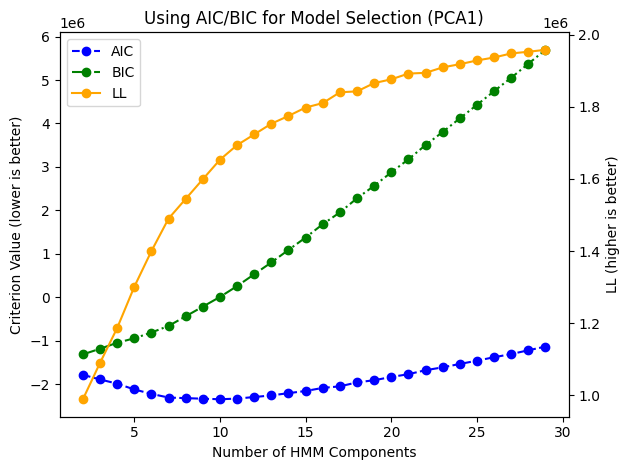

In [16]:
fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (PCA1)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

In [19]:
np.argmin(np.array(aic))+2

np.int64(10)

In [20]:
np.argmin(np.array(bic))+2

np.int64(2)

Model is not converging.  Current: 973488.098970073 is not greater than 973488.098970089. Delta is -1.594889909029007e-08
Model is not converging.  Current: 1140191.7887891142 is not greater than 1140191.7887891296. Delta is -1.5366822481155396e-08
Model is not converging.  Current: 1330212.6025630608 is not greater than 1339987.4398670825. Delta is -9774.837304021697
Fitting a model with 335306 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 335306 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 383215 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 383215 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 431126 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 431126 free scalar

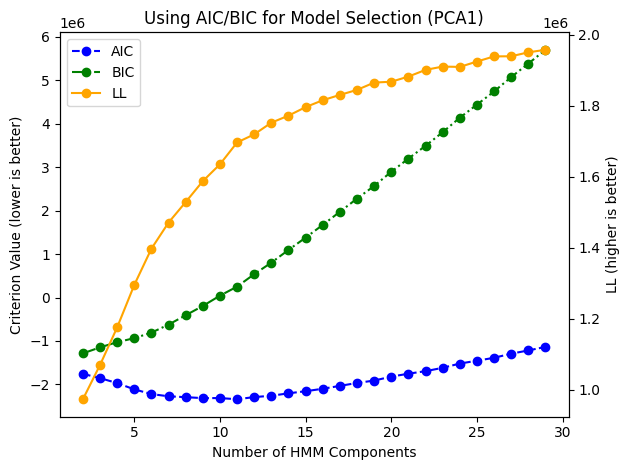

11
2


In [13]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_1)
        score = model.score(x_train_1)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_1))
    bic.append(best_model.bic(x_train_1))
    lls.append(best_model.score(x_train_1))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (PCA1)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

Model is not converging.  Current: 1140191.7887891142 is not greater than 1140191.7887891296. Delta is -1.5366822481155396e-08
Model is not converging.  Current: 1330212.6025607726 is not greater than 1339979.8709338421. Delta is -9767.268373069586
Fitting a model with 335306 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 335306 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 383215 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 383215 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 431126 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 431126 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 479039 free scalar par

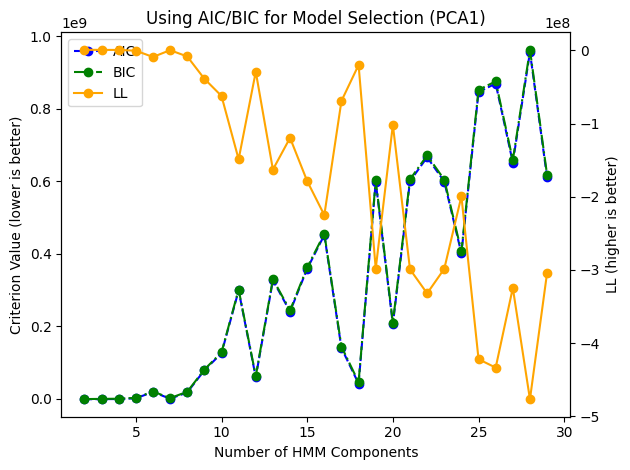

2
2


In [14]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_1)
        score = model.score(x_train_2)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_2))
    bic.append(best_model.bic(x_train_2))
    lls.append(best_model.score(x_train_2))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (PCA1)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

Model is not converging.  Current: 1081590.0473269417 is not greater than 1081590.047334487. Delta is -7.545342668890953e-06
Model is not converging.  Current: 1189403.133287415 is not greater than 1189403.133292026. Delta is -4.610978066921234e-06
Fitting a model with 335306 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 335306 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 383215 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 383215 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 431126 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 431126 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 479039 free scalar par

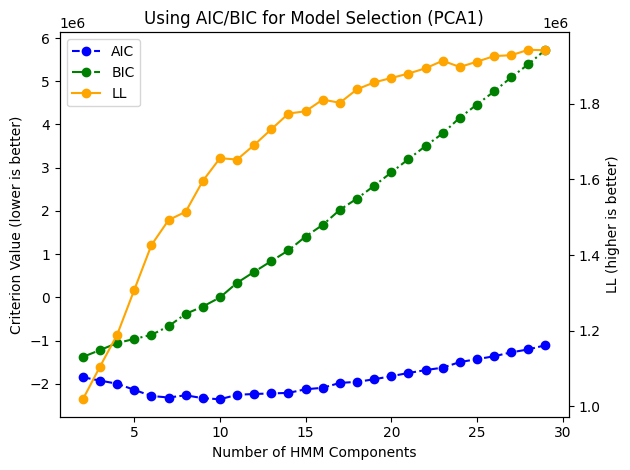

10
2


In [15]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_3)
        score = model.score(x_train_3)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_3))
    bic.append(best_model.bic(x_train_3))
    lls.append(best_model.score(x_train_3))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (PCA1)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

Fitting a model with 335306 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 335306 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 383215 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 383215 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 431126 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 431126 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 479039 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 479039 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 526954 free scalar parameters with 

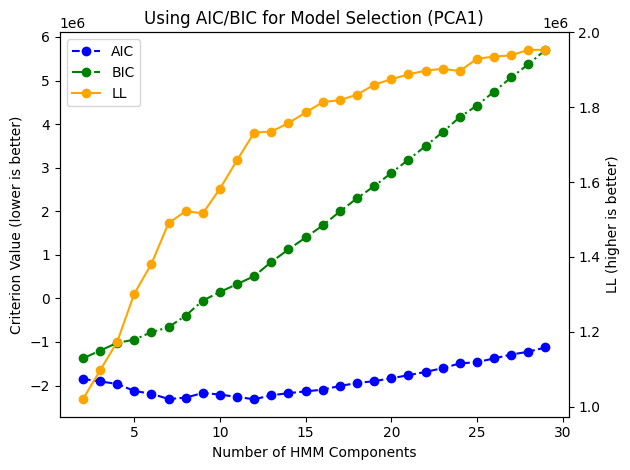

12
2


In [14]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_4)
        score = model.score(x_train_4)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_4))
    bic.append(best_model.bic(x_train_4))
    lls.append(best_model.score(x_train_4))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (PCA1)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

Building the models.

In [15]:
rs = check_random_state(546)
best_ll = None
best_model_0 = None

for i in range(10):
    model = GaussianHMM(10, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_0)
    score = model.score(x_train_0)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_0 = model

Fitting a model with 479039 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 479039 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 479039 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 479039 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 479039 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 479039 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 479039 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 479039 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 479039 free scalar parameters with 

In [16]:
rs = check_random_state(546)
best_ll = None
best_model_1 = None

for i in range(10):
    model = GaussianHMM(11, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_1)
    score = model.score(x_train_1)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_1 = model

Fitting a model with 526954 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 526954 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 526954 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 526954 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 526954 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 526954 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 526954 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 526954 free scalar parameters with only 310464 data points will result in a degenerate solution.
Model is not converging.  Current: 1690258.60626725 is n

In [17]:
rs = check_random_state(546)
best_ll = None
best_model_2 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_2)
    score = model.score(x_train_2)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_2 = model

Model is not converging.  Current: 980315.6445314259 is not greater than 980315.6445314428. Delta is -1.6880221664905548e-08


In [18]:
rs = check_random_state(546)
best_ll = None
best_model_3 = None

for i in range(10):
    model = GaussianHMM(10, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_3)
    score = model.score(x_train_3)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_3 = model

Fitting a model with 479039 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 479039 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 479039 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 479039 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 479039 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 479039 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 479039 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 479039 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 479039 free scalar parameters with 

In [19]:
rs = check_random_state(546)
best_ll = None
best_model_4 = None

for i in range(10):
    model = GaussianHMM(12, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_4)
    score = model.score(x_train_4)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_4 = model

Fitting a model with 574871 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 574871 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 574871 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 574871 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 574871 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 574871 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 574871 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 574871 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 574871 free scalar parameters with 

Actual classification

In [20]:
models = [best_model_0, best_model_1, best_model_2, best_model_3, best_model_4]

def HMM_classification(x):
    scores = []
    for model in models:
        scores.append(model.score(x))
    return np.argmax(scores)

preds = []
for i in range(n1):
    preds.append(HMM_classification((x_embed_pca1[i]).reshape(1,308)))

np.sum(preds == y_train)/n1

np.float64(0.26964285714285713)

In [21]:
x_embed_pca1_val = embed_pca1(x_val)
x_embed_pca1_test = embed_pca1(x_test)

preds = []
for i in range(n2):
    preds.append(HMM_classification((x_embed_pca1_val[i]).reshape(1,308)))

np.sum(preds == y_val)/n2

np.float64(0.26582278481012656)

In [22]:
preds = []
for i in range(n3):
    preds.append(HMM_classification((x_embed_pca1_test[i]).reshape(1,308)))

np.sum(preds == y_test)/n3

np.float64(0.2678375411635565)

Let's start over with the number of states chosen according to BIC.

In [37]:
rs = check_random_state(546)
best_ll = None
best_model_0 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_0)
    score = model.score(x_train_0)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_0 = model

best_ll = None
best_model_1 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_1)
    score = model.score(x_train_1)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_1 = model

best_ll = None
best_model_2 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_2)
    score = model.score(x_train_2)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_2 = model

best_ll = None
best_model_3 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_3)
    score = model.score(x_train_3)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_3 = model

best_ll = None
best_model_4 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_4)
    score = model.score(x_train_4)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_4 = model

Model is not converging.  Current: 989097.7912725165 is not greater than 989097.7912762528. Delta is -3.736349754035473e-06
Model is not converging.  Current: 980390.435615279 is not greater than 980390.4356197028. Delta is -4.423782229423523e-06
Model is not converging.  Current: 984428.0679950069 is not greater than 989197.6668387483. Delta is -4769.598843741347
Model is not converging.  Current: 975625.6142305112 is not greater than 975625.61423053. Delta is -1.8742866814136505e-08
Model is not converging.  Current: 998914.8746785774 is not greater than 998914.8746786049. Delta is -2.7474015951156616e-08
Model is not converging.  Current: 1017658.2110800743 is not greater than 1017658.2110801007. Delta is -2.6426278054714203e-08
Model is not converging.  Current: 1021051.0360730436 is not greater than 1021051.0360813908. Delta is -8.34721140563488e-06
Model is not converging.  Current: 1020823.8996796054 is not greater than 1020823.899683077. Delta is -3.471621312201023e-06
Model is

In [38]:
models = [best_model_0, best_model_1, best_model_2, best_model_3, best_model_4]

def HMM_classification(x):
    scores = []
    for model in models:
        scores.append(model.score(x))
    return np.argmax(scores)

preds = []
for i in range(n1):
    preds.append(HMM_classification((x_embed_pca1[i]).reshape(1,308)))

np.sum(preds == y_train)/n1

np.float64(0.4734126984126984)

In [39]:
x_embed_pca1_val = embed_pca1(x_val)
x_embed_pca1_test = embed_pca1(x_test)

preds = []
for i in range(n2):
    preds.append(HMM_classification((x_embed_pca1_val[i]).reshape(1,308)))

np.sum(preds == y_val)/n2

np.float64(0.2990506329113924)

In [40]:
preds = []
for i in range(n3):
    preds.append(HMM_classification((x_embed_pca1_test[i]).reshape(1,308)))

np.sum(preds == y_test)/n3

np.float64(0.31448957189901205)

### PCA2

In [23]:
x_train_0 = (x_embed_pca2[:1008]).reshape(1008, r*2)
x_train_1 = (x_embed_pca2[1008:2016]).reshape(1008, r*2)
x_train_2 = (x_embed_pca2[2016:3024]).reshape(1008, r*2)
x_train_3 = (x_embed_pca2[3024:4032]).reshape(1008, r*2)
x_train_4 = (x_embed_pca2[4032:]).reshape(1008, r*2)

Choosing the number of possible states.

In [24]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_0)
        score = model.score(x_train_0)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_0))
    bic.append(best_model.bic(x_train_0))
    lls.append(best_model.score(x_train_0))

Model is not converging.  Current: 2816452.114368132 is not greater than 2816452.114368152. Delta is -2.0023435354232788e-08
Fitting a model with 762623 free scalar parameters with only 620928 data points will result in a degenerate solution.
Fitting a model with 762623 free scalar parameters with only 620928 data points will result in a degenerate solution.
Fitting a model with 953284 free scalar parameters with only 620928 data points will result in a degenerate solution.
Fitting a model with 953284 free scalar parameters with only 620928 data points will result in a degenerate solution.
Fitting a model with 1143947 free scalar parameters with only 620928 data points will result in a degenerate solution.
Fitting a model with 1143947 free scalar parameters with only 620928 data points will result in a degenerate solution.
Fitting a model with 1334612 free scalar parameters with only 620928 data points will result in a degenerate solution.
Fitting a model with 1334612 free scalar param

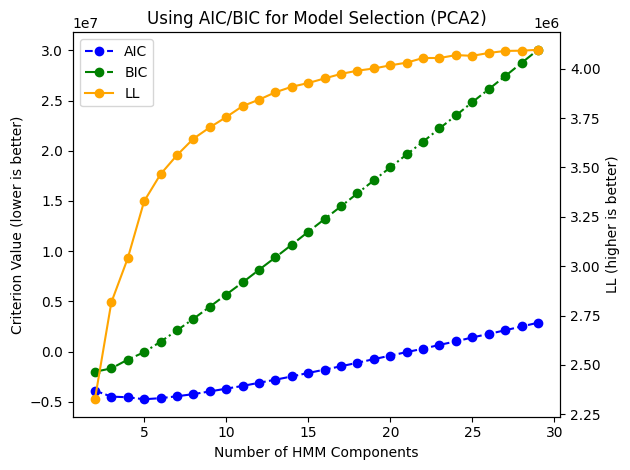

In [25]:
fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (PCA2)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

In [26]:
np.argmin(np.array(aic))+2

np.int64(5)

In [27]:
np.argmin(np.array(bic))+2

np.int64(2)

In [ ]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_1)
        score = model.score(x_train_1)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_1))
    bic.append(best_model.bic(x_train_1))
    lls.append(best_model.score(x_train_1))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (PCA2)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

In [ ]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_2)
        score = model.score(x_train_2)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_2))
    bic.append(best_model.bic(x_train_2))
    lls.append(best_model.score(x_train_2))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (PCA2)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

In [ ]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_3)
        score = model.score(x_train_3)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_3))
    bic.append(best_model.bic(x_train_3))
    lls.append(best_model.score(x_train_3))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (PCA2)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

In [ ]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_4)
        score = model.score(x_train_4)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_4))
    bic.append(best_model.bic(x_train_4))
    lls.append(best_model.score(x_train_4))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (PCA2)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

Building the models

In [28]:
rs = check_random_state(546)
best_ll = None
best_model_0 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_0)
    score = model.score(x_train_0)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_0 = model

Model is not converging.  Current: 2262797.770937598 is not greater than 2262797.770937636. Delta is -3.818422555923462e-08
Model is not converging.  Current: 2303747.7151937857 is not greater than 2303747.7151938044. Delta is -1.862645149230957e-08
Model is not converging.  Current: 2257024.61219383 is not greater than 2257024.6121938704. Delta is -4.0512531995773315e-08


In [29]:
rs = check_random_state(546)
best_ll = None
best_model_1 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_1)
    score = model.score(x_train_1)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_1 = model

Model is not converging.  Current: 2333055.5454508644 is not greater than 2333055.5454508876. Delta is -2.3283064365386963e-08
Model is not converging.  Current: 2319044.9915539646 is not greater than 2319044.9915539906. Delta is -2.60770320892334e-08
Model is not converging.  Current: 2288741.2805253454 is not greater than 2288741.280525399. Delta is -5.3551048040390015e-08
Model is not converging.  Current: 2280951.4193899212 is not greater than 2280951.4193899618. Delta is -4.0512531995773315e-08
Model is not converging.  Current: 2289357.3940638416 is not greater than 2289357.3940638793. Delta is -3.771856427192688e-08
Model is not converging.  Current: 2277911.0017472743 is not greater than 2277911.0017473083. Delta is -3.3993273973464966e-08
Model is not converging.  Current: 2328907.354530628 is not greater than 2328907.3545306497. Delta is -2.1886080503463745e-08
Model is not converging.  Current: 2271008.2747584116 is not greater than 2271008.274758431. Delta is -1.95577740669

In [30]:
rs = check_random_state(546)
best_ll = None
best_model_2 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_2)
    score = model.score(x_train_2)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_2 = model

Model is not converging.  Current: 2318113.629930782 is not greater than 2324033.0723549174. Delta is -5919.442424135283
Model is not converging.  Current: 2312652.616740995 is not greater than 2312895.142477366. Delta is -242.52573637105525
Model is not converging.  Current: 2317418.0049477145 is not greater than 2317418.0049477583. Delta is -4.377216100692749e-08
Model is not converging.  Current: 2270843.722320046 is not greater than 2271281.354718604. Delta is -437.6323985583149


In [31]:
rs = check_random_state(546)
best_ll = None
best_model_3 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_3)
    score = model.score(x_train_3)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_3 = model

Model is not converging.  Current: 2318833.4034579326 is not greater than 2318833.4034579545. Delta is -2.1886080503463745e-08
Model is not converging.  Current: 2323245.1917106356 is not greater than 2323928.56202018. Delta is -683.3703095442615
Model is not converging.  Current: 2334029.5114524886 is not greater than 2335549.354523994. Delta is -1519.8430715054274


In [32]:
rs = check_random_state(546)
best_ll = None
best_model_4 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_4)
    score = model.score(x_train_4)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_4 = model

Model is not converging.  Current: 2211760.717179268 is not greater than 2211760.7171860104. Delta is -6.742309778928757e-06
Model is not converging.  Current: 2243346.50028837 is not greater than 2243346.5002884073. Delta is -3.725290298461914e-08
Model is not converging.  Current: 2207504.5454552853 is not greater than 2207504.5454553007. Delta is -1.5366822481155396e-08
Model is not converging.  Current: 2289404.7325532646 is not greater than 2289404.732553461. Delta is -1.9650906324386597e-07


Actual classification

In [33]:
models = [best_model_0, best_model_1, best_model_2, best_model_3, best_model_4]

def HMM_classification(x):
    scores = []
    for model in models:
        scores.append(model.score(x))
    return np.argmax(scores)

preds = []
for i in range(n1):
    preds.append(HMM_classification((x_embed_pca2[i]).reshape(1,308*2)))

np.sum(preds == y_train)/n1

np.float64(0.5686507936507936)

In [34]:
x_embed_pca2_val = embed_pca2(x_val)
x_embed_pca2_test = embed_pca2(x_test)

preds = []
for i in range(n2):
    preds.append(HMM_classification((x_embed_pca2_val[i]).reshape(1,308*2)))

np.sum(preds == y_val)/n2

np.float64(0.04430379746835443)

In [35]:
preds = []
for i in range(n3):
    preds.append(HMM_classification((x_embed_pca2_val[i]).reshape(1,308*2)))

np.sum(preds == y_test)/n3

np.float64(0.042810098792535674)

### LR

In [41]:
x_train_0 = (x_embed_lr[:1008]).reshape(1008, 2)
x_train_1 = (x_embed_lr[1008:2016]).reshape(1008, 2)
x_train_2 = (x_embed_lr[2016:3024]).reshape(1008, 2)
x_train_3 = (x_embed_lr[3024:4032]).reshape(1008, 2)
x_train_4 = (x_embed_lr[4032:]).reshape(1008, 2)

Choosing the number of states

In [43]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_0)
        score = model.score(x_train_0)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_0))
    bic.append(best_model.bic(x_train_0))
    lls.append(best_model.score(x_train_0))

ValueError: 'covars' must be symmetric, positive-definite

In [ ]:
fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (LR)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

In [ ]:
np.argmin(np.array(aic))+2

In [ ]:
np.argmin(np.array(bic))+2

In [44]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_1)
        score = model.score(x_train_1)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_1))
    bic.append(best_model.bic(x_train_1))
    lls.append(best_model.score(x_train_1))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (LR)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

ValueError: 'covars' must be symmetric, positive-definite

In [ ]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_2)
        score = model.score(x_train_2)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_2))
    bic.append(best_model.bic(x_train_2))
    lls.append(best_model.score(x_train_2))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (LR)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

In [ ]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_3)
        score = model.score(x_train_3)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_3))
    bic.append(best_model.bic(x_train_3))
    lls.append(best_model.score(x_train_3))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (LR)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

In [ ]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_4)
        score = model.score(x_train_4)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_4))
    bic.append(best_model.bic(x_train_4))
    lls.append(best_model.score(x_train_4))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (LR)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

Building the models

In [ ]:
rs = check_random_state(546)
best_ll = None
best_model_0 = None

for i in range(10):
    model = GaussianHMM(20, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_0)
    score = model.score(x_train_0)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_0 = model

In [ ]:
rs = check_random_state(546)
best_ll = None
best_model_1 = None

for i in range(10):
    model = GaussianHMM(20, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_1)
    score = model.score(x_train_1)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_1 = model

In [ ]:
rs = check_random_state(546)
best_ll = None
best_model_2 = None

for i in range(10):
    model = GaussianHMM(20, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_2)
    score = model.score(x_train_2)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_2 = model

In [ ]:
rs = check_random_state(546)
best_ll = None
best_model_3 = None

for i in range(10):
    model = GaussianHMM(20, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_3)
    score = model.score(x_train_3)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_3 = model

In [ ]:
rs = check_random_state(546)
best_ll = None
best_model_4 = None

for i in range(10):
    model = GaussianHMM(20, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_4)
    score = model.score(x_train_4)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_4 = model

Actual classification

In [ ]:
models = [best_model_0, best_model_1, best_model_2, best_model_3, best_model_4]

def HMM_classification(x):
    scores = []
    for model in models:
        scores.append(model.score(x))
    return np.argmax(scores)

preds = []
for i in range(n1):
    preds.append(HMM_classification((x_embed_lr[i]).reshape(1,2)))

np.sum(preds == y_train)/n1

In [ ]:
x_embed_lr_val = embed_lr(x_val)
x_embed_lr_test = embed_lr(x_test)

preds = []
for i in range(n2):
    preds.append(HMM_classification((x_embed_lr_val[i]).reshape(1,2)))

np.sum(preds == y_val)/n2

In [ ]:
preds = []
for i in range(n3):
    preds.append(HMM_classification((x_embed_lr_test[i]).reshape(1,2)))

np.sum(preds == y_test)/n3

### SVD1

In [10]:
x_train_0 = (x_embed_svd1[:1008]).reshape(1008, 2)
x_train_1 = (x_embed_svd1[1008:2016]).reshape(1008, 2)
x_train_2 = (x_embed_svd1[2016:3024]).reshape(1008, 2)
x_train_3 = (x_embed_svd1[3024:4032]).reshape(1008, 2)
x_train_4 = (x_embed_svd1[4032:]).reshape(1008, 2)

Choosing the number of possible states.

Model is not converging.  Current: -6383.225860900337 is not greater than -6381.329624755553. Delta is -1.8962361447838703
Model is not converging.  Current: -6353.627203856654 is not greater than -6347.549463978551. Delta is -6.077739878102875
Model is not converging.  Current: -6385.577778142826 is not greater than -6384.483905922846. Delta is -1.0938722199798576
Model is not converging.  Current: -6303.836352364179 is not greater than -6301.627323380737. Delta is -2.2090289834422947
Model is not converging.  Current: -6290.564478590922 is not greater than -6290.4604143308525. Delta is -0.1040642600692081


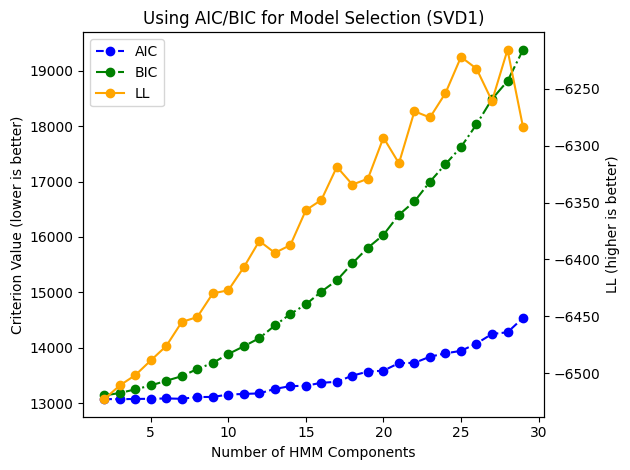

3
2


In [11]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_0)
        score = model.score(x_train_0)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_0))
    bic.append(best_model.bic(x_train_0))
    lls.append(best_model.score(x_train_0))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (SVD1)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

Model is not converging.  Current: -6411.768578283195 is not greater than -6409.026349736899. Delta is -2.7422285462962463


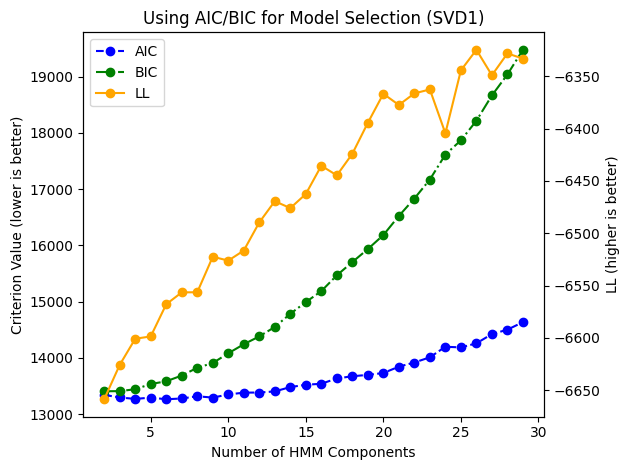

6
2


In [12]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_1)
        score = model.score(x_train_1)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_1))
    bic.append(best_model.bic(x_train_1))
    lls.append(best_model.score(x_train_1))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (SVD1)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

Model is not converging.  Current: -6187.895585223298 is not greater than -6186.92426820753. Delta is -0.9713170157683635


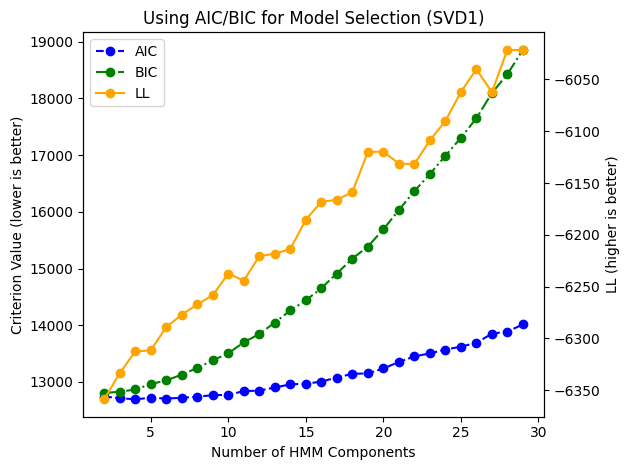

4
2


In [13]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_2)
        score = model.score(x_train_2)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_2))
    bic.append(best_model.bic(x_train_2))
    lls.append(best_model.score(x_train_2))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (SVD1)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

Model is not converging.  Current: -5408.123328993953 is not greater than -5406.808030285181. Delta is -1.3152987087714791
Model is not converging.  Current: -5359.464203180354 is not greater than -5356.33756382643. Delta is -3.1266393539244746


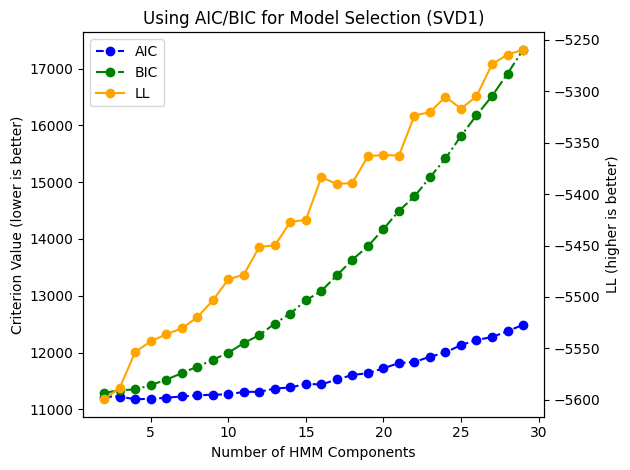

4
2


In [14]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_3)
        score = model.score(x_train_3)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_3))
    bic.append(best_model.bic(x_train_3))
    lls.append(best_model.score(x_train_3))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (SVD1)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

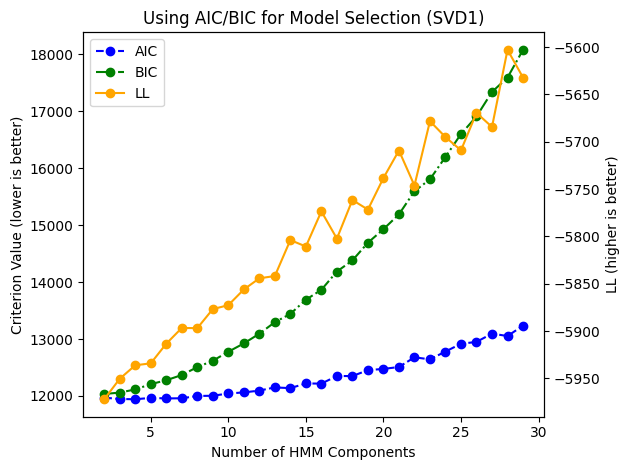

4
2


In [15]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_4)
        score = model.score(x_train_4)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_4))
    bic.append(best_model.bic(x_train_4))
    lls.append(best_model.score(x_train_4))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (SVD1)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

Building the models.

In [16]:
rs = check_random_state(546)
best_ll = None
best_model_0 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_0)
    score = model.score(x_train_0)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_0 = model

In [17]:
rs = check_random_state(546)
best_ll = None
best_model_1 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_1)
    score = model.score(x_train_1)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_1 = model

Model is not converging.  Current: -6683.610559870852 is not greater than -6681.604407498172. Delta is -2.006152372679935


In [18]:
rs = check_random_state(546)
best_ll = None
best_model_2 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_2)
    score = model.score(x_train_2)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_2 = model

In [19]:
rs = check_random_state(546)
best_ll = None
best_model_3 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_3)
    score = model.score(x_train_3)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_3 = model

In [20]:
rs = check_random_state(546)
best_ll = None
best_model_4 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_4)
    score = model.score(x_train_4)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_4 = model

Model is not converging.  Current: -6012.687518628113 is not greater than -6009.45482652459. Delta is -3.2326921035228224


Actual classification.

In [23]:
models = [best_model_0, best_model_1, best_model_2, best_model_3, best_model_4]

def HMM_classification(x):
    scores = []
    for model in models:
        scores.append(model.score(x))
    return np.argmax(scores)

preds = []
for i in range(n1):
    preds.append(HMM_classification((x_embed_svd1[i]).reshape(1,2)))

np.sum(preds == y_train)/n1

np.float64(0.35)

In [24]:
x_embed_svd1_val = embed_svd1(x_val)
x_embed_svd1_test = embed_svd1(x_test)

preds = []
for i in range(n2):
    preds.append(HMM_classification((x_embed_svd1_val[i]).reshape(1,2)))

np.sum(preds == y_val)/n2

np.float64(0.33860759493670883)

In [25]:
preds = []
for i in range(n3):
    preds.append(HMM_classification((x_embed_svd1_val[i]).reshape(1,2)))

np.sum(preds == y_test)/n3

np.float64(0.3046103183315038)

### SVD2

In [27]:
x_train_0 = (x_embed_svd2[:1008]).reshape(1008, 100)
x_train_1 = (x_embed_svd2[1008:2016]).reshape(1008, 100)
x_train_2 = (x_embed_svd2[2016:3024]).reshape(1008, 100)
x_train_3 = (x_embed_svd2[3024:4032]).reshape(1008, 100)
x_train_4 = (x_embed_svd2[4032:]).reshape(1008, 100)

Choosing the number of possible states

In [ ]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_0)
        score = model.score(x_train_0)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_0))
    bic.append(best_model.bic(x_train_0))
    lls.append(best_model.score(x_train_0))

Model is not converging.  Current: 340107.815986295 is not greater than 343309.65828012716. Delta is -3201.84229383216
Model is not converging.  Current: 339116.6811682543 is not greater than 344953.16916931205. Delta is -5836.488001057762
Model is not converging.  Current: 339666.85298818187 is not greater than 339666.85309843696. Delta is -0.00011025508865714073
Model is not converging.  Current: 342220.17874101276 is not greater than 342220.1787430565. Delta is -2.043729182332754e-06
Model is not converging.  Current: 342682.13052872126 is not greater than 342682.13053221884. Delta is -3.4975819289684296e-06
Model is not converging.  Current: 346243.86308477574 is not greater than 348029.2309917353. Delta is -1785.3679069595528
Model is not converging.  Current: 346958.95905774256 is not greater than 347541.7248142813. Delta is -582.7657565387199
Model is not converging.  Current: 348133.41348855745 is not greater than 359634.9998488799. Delta is -11501.586360322428
Model is not con

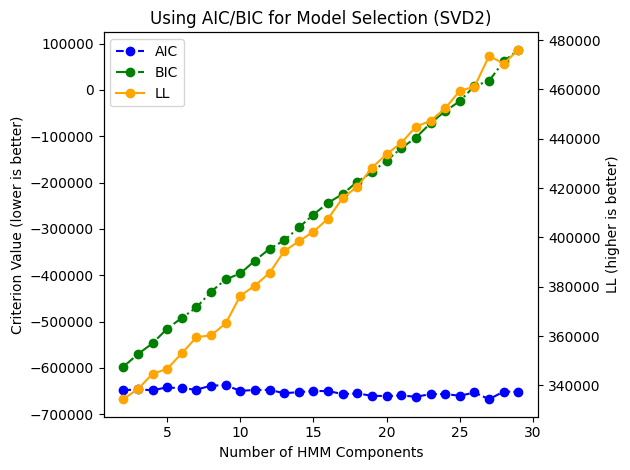

In [29]:
fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (SVD2)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

In [30]:
np.argmin(np.array(aic))+2

np.int64(27)

In [31]:
np.argmin(np.array(bic))+2

np.int64(2)

Model is not converging.  Current: 334408.3681139181 is not greater than 334408.36811428104. Delta is -3.629247657954693e-07
Model is not converging.  Current: 337664.1977318542 is not greater than 337664.19793157774. Delta is -0.0001997235231101513
Model is not converging.  Current: 344188.880338973 is not greater than 347467.45336686727. Delta is -3278.57302789425
Model is not converging.  Current: 344677.2226889544 is not greater than 350121.58687935554. Delta is -5444.36419040116
Model is not converging.  Current: 346740.4600327084 is not greater than 346740.4600463021. Delta is -1.3593700714409351e-05
Model is not converging.  Current: 351872.6117859606 is not greater than 355126.8938141312. Delta is -3254.2820281705935
Model is not converging.  Current: 352988.2450121965 is not greater than 354178.54095864325. Delta is -1190.2959464467713
Model is not converging.  Current: 359543.05345627863 is not greater than 368667.60649832315. Delta is -9124.553042044514
Model is not convergi

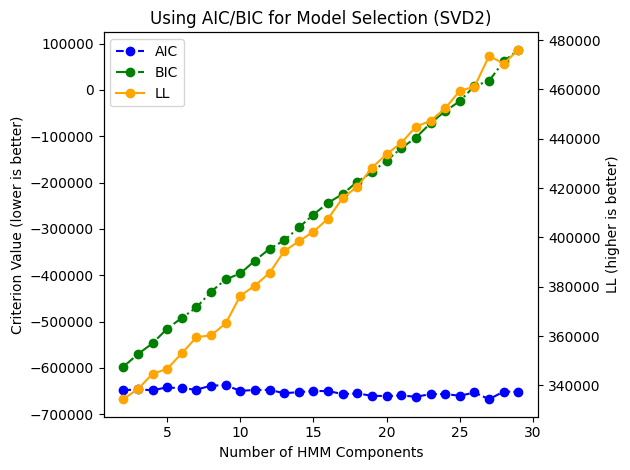

27
2


In [28]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_1)
        score = model.score(x_train_1)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_1))
    bic.append(best_model.bic(x_train_1))
    lls.append(best_model.score(x_train_1))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (SVD2)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

Model is not converging.  Current: 340162.23230534047 is not greater than 340162.2325735857. Delta is -0.00026824523229151964
Model is not converging.  Current: 339457.5720831989 is not greater than 339457.5720923668. Delta is -9.16793942451477e-06
Model is not converging.  Current: 345917.364656095 is not greater than 345917.364703576. Delta is -4.7481036745011806e-05
Model is not converging.  Current: 347730.15325623733 is not greater than 358110.73995445773. Delta is -10380.586698220402
Model is not converging.  Current: 353765.2831704077 is not greater than 360086.63776177843. Delta is -6321.354591370735
Model is not converging.  Current: 350986.75768013 is not greater than 350986.7576807293. Delta is -5.993060767650604e-07
Model is not converging.  Current: 364647.5640302235 is not greater than 372491.14161978493. Delta is -7843.577589561406
Model is not converging.  Current: 362984.53408904525 is not greater than 380614.4262786261. Delta is -17629.89218958083
Model is not converg

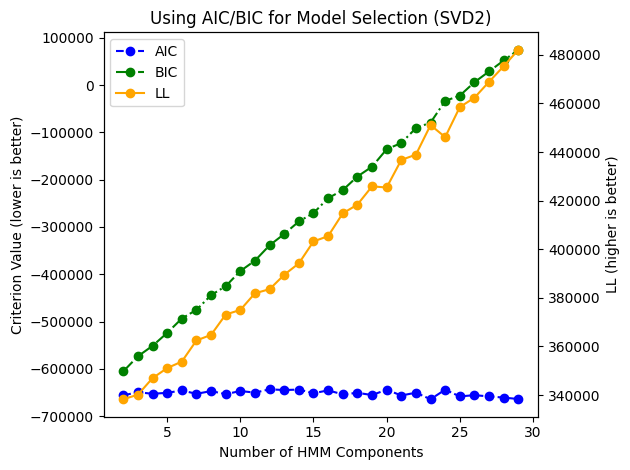

23
2


In [32]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_2)
        score = model.score(x_train_2)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_2))
    bic.append(best_model.bic(x_train_2))
    lls.append(best_model.score(x_train_2))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (SVD2)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

Model is not converging.  Current: 351499.1989431159 is not greater than 351499.1989431493. Delta is -3.341119736433029e-08
Model is not converging.  Current: 351811.8856575299 is not greater than 351811.8856637911. Delta is -6.261165253818035e-06
Model is not converging.  Current: 354712.8534937963 is not greater than 357660.9416617691. Delta is -2948.0881679728045
Model is not converging.  Current: 360363.87701638386 is not greater than 362753.4989857924. Delta is -2389.6219694085303
Model is not converging.  Current: 370050.3344900152 is not greater than 378907.1745190926. Delta is -8856.84002907743
Model is not converging.  Current: 370819.26839574904 is not greater than 371011.6927613787. Delta is -192.42436562967487
Model is not converging.  Current: 376455.3592710078 is not greater than 386270.0780506219. Delta is -9814.718779614079
Model is not converging.  Current: 375717.22544638737 is not greater than 377067.55499388976. Delta is -1350.3295475023915
Model is not converging. 

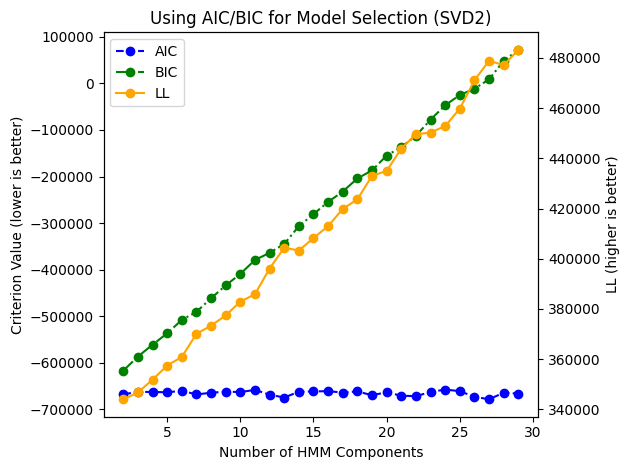

27
2


In [33]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_3)
        score = model.score(x_train_3)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_3))
    bic.append(best_model.bic(x_train_3))
    lls.append(best_model.score(x_train_3))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (SVD2)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

Model is not converging.  Current: 333741.9247342946 is not greater than 333741.9247350599. Delta is -7.653143256902695e-07
Model is not converging.  Current: 335812.73390900803 is not greater than 335812.73443298455. Delta is -0.0005239765159785748
Model is not converging.  Current: 335628.1315260927 is not greater than 335628.1315688115. Delta is -4.271877696737647e-05
Model is not converging.  Current: 344313.73894553585 is not greater than 348925.89675112336. Delta is -4612.157805587514
Model is not converging.  Current: 344564.6341815171 is not greater than 344564.63418242463. Delta is -9.075156413018703e-07
Model is not converging.  Current: 350332.6974760034 is not greater than 356039.9295155828. Delta is -5707.232039579423
Model is not converging.  Current: 361660.2399358106 is not greater than 366963.13709938765. Delta is -5302.897163577029
Model is not converging.  Current: 359557.52841912844 is not greater than 363228.08917782496. Delta is -3670.5607586965198
Model is not co

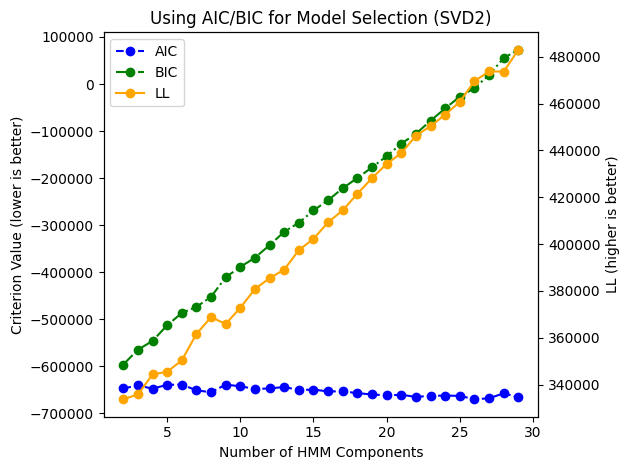

26
2


In [34]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_4)
        score = model.score(x_train_4)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_4))
    bic.append(best_model.bic(x_train_4))
    lls.append(best_model.score(x_train_4))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (SVD2)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

Model 0

In [35]:
rs = check_random_state(546)
best_ll = None
best_model_0 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_0)
    score = model.score(x_train_0)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_0 = model

Model is not converging.  Current: 340107.81598629354 is not greater than 343309.65828823735. Delta is -3201.842301943805
Model is not converging.  Current: 339116.6811682543 is not greater than 344953.16916931205. Delta is -5836.488001057762
Model is not converging.  Current: 339666.85298818187 is not greater than 339666.85309843696. Delta is -0.00011025508865714073
Model is not converging.  Current: 339445.4726450261 is not greater than 339445.47264541325. Delta is -3.871391527354717e-07
Model is not converging.  Current: 338748.69341188495 is not greater than 338748.69356662605. Delta is -0.00015474110841751099


Model 1

In [36]:
rs = check_random_state(546)
best_ll = None
best_model_1 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_1)
    score = model.score(x_train_1)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_1 = model

Model is not converging.  Current: 334408.3681139181 is not greater than 334408.36811428104. Delta is -3.629247657954693e-07
Model is not converging.  Current: 334218.1522467479 is not greater than 334218.15243517567. Delta is -0.0001884277444332838
Model is not converging.  Current: 334455.13129039085 is not greater than 334455.1317323583. Delta is -0.00044196745147928596
Model is not converging.  Current: 334352.1861408646 is not greater than 334352.18700441613. Delta is -0.0008635515114292502
Model is not converging.  Current: 334511.78979818383 is not greater than 334511.790003223. Delta is -0.00020503916312009096
Model is not converging.  Current: 334691.49929033255 is not greater than 334691.49940538546. Delta is -0.0001150529133155942


Model 2

In [37]:
rs = check_random_state(546)
best_ll = None
best_model_2 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_2)
    score = model.score(x_train_2)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_2 = model

Model is not converging.  Current: 336603.4938447614 is not greater than 336603.4938608833. Delta is -1.6121892258524895e-05
Model is not converging.  Current: 337059.4472495273 is not greater than 337059.44837680645. Delta is -0.0011272791307419538
Model is not converging.  Current: 336698.13582858926 is not greater than 336698.1361217234. Delta is -0.00029313412960618734


Model 3

In [38]:
rs = check_random_state(546)
best_ll = None
best_model_3 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_3)
    score = model.score(x_train_3)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_3 = model

Model is not converging.  Current: 343886.0111832144 is not greater than 343886.01127167174. Delta is -8.845736738294363e-05
Model is not converging.  Current: 343877.1591912268 is not greater than 343877.15922779246. Delta is -3.656564513221383e-05
Model is not converging.  Current: 344100.1829839996 is not greater than 344100.18299263483. Delta is -8.635222911834717e-06
Model is not converging.  Current: 343778.4024988517 is not greater than 343778.40303141065. Delta is -0.000532558944541961


Model 4

In [39]:
rs = check_random_state(546)
best_ll = None
best_model_4 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_4)
    score = model.score(x_train_4)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_4 = model

Model is not converging.  Current: 333741.9247342946 is not greater than 333741.9247350599. Delta is -7.653143256902695e-07
Model is not converging.  Current: 332722.995851022 is not greater than 332722.99585414474. Delta is -3.1227245926856995e-06


Actual classification

In [40]:
models = [best_model_0, best_model_1, best_model_2, best_model_3, best_model_4]

def HMM_classification(x):
    scores = []
    for model in models:
        scores.append(model.score(x))
    return np.argmax(scores)

In [41]:
preds = []
for i in range(n1):
    preds.append(HMM_classification((x_embed_svd2[i]).reshape(1,100)))

In [42]:
np.sum(preds == y_train)/n1

np.float64(0.6069444444444444)

In [43]:
x_embed_svd2_val = embed_svd2(x_val)
x_embed_svd2_test = embed_svd2(x_test)

preds = []
for i in range(n2):
    preds.append(HMM_classification((x_embed_svd2_val[i]).reshape(1,100)))

np.sum(preds == y_val)/n2

np.float64(0.42563291139240506)

In [44]:
preds = []
for i in range(n3):
    preds.append(HMM_classification((x_embed_svd2_val[i]).reshape(1,100)))

np.sum(preds == y_test)/n3

np.float64(0.4045005488474204)

### SVD3

In [45]:
x_train_0 = (x_embed_svd3[:1008]).reshape(1008, c)
x_train_1 = (x_embed_svd3[1008:2016]).reshape(1008, c)
x_train_2 = (x_embed_svd3[2016:3024]).reshape(1008, c)
x_train_3 = (x_embed_svd3[3024:4032]).reshape(1008, c)
x_train_4 = (x_embed_svd3[4032:]).reshape(1008, c)

Choosing the number of possible states.

Model is not converging.  Current: 1799801.7456466183 is not greater than 1799801.745668387. Delta is -2.1768733859062195e-05
Model is not converging.  Current: 1809736.9431140434 is not greater than 1809736.9431945551. Delta is -8.051167242228985e-05
Model is not converging.  Current: 1873121.7612367666 is not greater than 1873121.761295826. Delta is -5.905935540795326e-05
Fitting a model with 544074 free scalar parameters with only 468720 data points will result in a degenerate solution.
Fitting a model with 544074 free scalar parameters with only 468720 data points will result in a degenerate solution.
Model is not converging.  Current: 1911835.3895072038 is not greater than 1911835.3895581015. Delta is -5.0897710025310516e-05
Fitting a model with 652895 free scalar parameters with only 468720 data points will result in a degenerate solution.
Fitting a model with 652895 free scalar parameters with only 468720 data points will result in a degenerate solution.
Model is not converging.

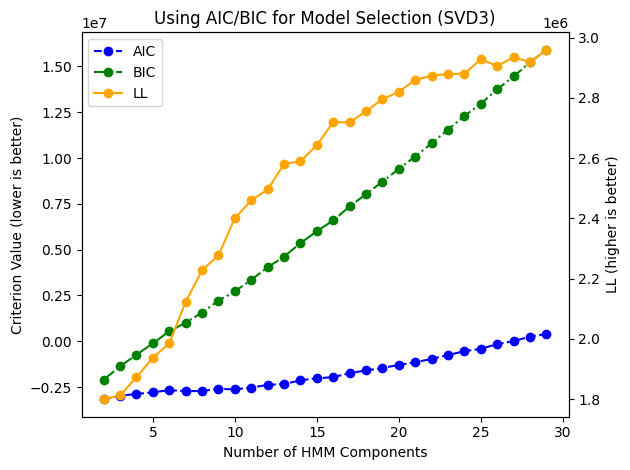

2
2


In [46]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_0)
        score = model.score(x_train_0)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_0))
    bic.append(best_model.bic(x_train_0))
    lls.append(best_model.score(x_train_0))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (SVD3)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

In [ ]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_1)
        score = model.score(x_train_1)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_1))
    bic.append(best_model.bic(x_train_1))
    lls.append(best_model.score(x_train_1))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (SVD3)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

In [ ]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_2)
        score = model.score(x_train_2)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_2))
    bic.append(best_model.bic(x_train_2))
    lls.append(best_model.score(x_train_2))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (SVD3)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

In [ ]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_3)
        score = model.score(x_train_3)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_3))
    bic.append(best_model.bic(x_train_3))
    lls.append(best_model.score(x_train_3))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (SVD3)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

In [ ]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_4)
        score = model.score(x_train_4)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_4))
    bic.append(best_model.bic(x_train_4))
    lls.append(best_model.score(x_train_4))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (SVD3)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

Building the models.

In [48]:
rs = check_random_state(546)
best_ll = None
best_model_0 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_0)
    score = model.score(x_train_0)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_0 = model

Model is not converging.  Current: 1799801.7456120234 is not greater than 1799801.7457357107. Delta is -0.00012368732132017612
Model is not converging.  Current: 1799319.0331742307 is not greater than 1799319.0333906724. Delta is -0.00021644169464707375
Model is not converging.  Current: 1801298.806505471 is not greater than 1801298.8065087534. Delta is -3.282446414232254e-06
Model is not converging.  Current: 1800409.7533137694 is not greater than 1800409.7533326042. Delta is -1.8834834918379784e-05
Model is not converging.  Current: 1801341.2551387073 is not greater than 1801341.2553752211. Delta is -0.0002365137916058302
Model is not converging.  Current: 1800525.6770305748 is not greater than 1800525.67703354. Delta is -2.9653310775756836e-06
Model is not converging.  Current: 1800746.5307831564 is not greater than 1800746.5308249274. Delta is -4.177098162472248e-05


In [49]:
rs = check_random_state(546)
best_ll = None
best_model_1 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_1)
    score = model.score(x_train_1)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_1 = model

Model is not converging.  Current: 1814408.9249449808 is not greater than 1814408.9249640256. Delta is -1.9044848158955574e-05
Model is not converging.  Current: 1813596.8536741438 is not greater than 1813596.8538957515. Delta is -0.0002216077409684658
Model is not converging.  Current: 1814410.143460557 is not greater than 1814410.1434795877. Delta is -1.9030645489692688e-05
Model is not converging.  Current: 1814807.3266692208 is not greater than 1814807.3267303247. Delta is -6.110384128987789e-05
Model is not converging.  Current: 1816384.8962660918 is not greater than 1816384.8962884336. Delta is -2.2341730073094368e-05
Model is not converging.  Current: 1816624.191316805 is not greater than 1816624.191352383. Delta is -3.55779193341732e-05


In [50]:
rs = check_random_state(546)
best_ll = None
best_model_2 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_2)
    score = model.score(x_train_2)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_2 = model

Model is not converging.  Current: 1803598.058085021 is not greater than 1803598.0581256938. Delta is -4.067271947860718e-05
Model is not converging.  Current: 1799764.0466243927 is not greater than 1799764.0466603287. Delta is -3.5936012864112854e-05
Model is not converging.  Current: 1806359.6349475281 is not greater than 1806359.6350056913. Delta is -5.816319026052952e-05
Model is not converging.  Current: 1808472.5368730389 is not greater than 1808472.5368974623. Delta is -2.4423468858003616e-05
Model is not converging.  Current: 1805694.3425679174 is not greater than 1805694.342737539. Delta is -0.00016962154768407345
Model is not converging.  Current: 1806681.4550376192 is not greater than 1806681.4551480217. Delta is -0.00011040247045457363
Model is not converging.  Current: 1807227.5877075556 is not greater than 1807227.5877498747. Delta is -4.231906495988369e-05


In [51]:
rs = check_random_state(546)
best_ll = None
best_model_3 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_3)
    score = model.score(x_train_3)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_3 = model

Model is not converging.  Current: 1843475.7197184802 is not greater than 1843475.7197488993. Delta is -3.0419090762734413e-05
Model is not converging.  Current: 1841573.3156314555 is not greater than 1841573.3156490875. Delta is -1.7632031813263893e-05
Model is not converging.  Current: 1841913.1534790294 is not greater than 1841913.153541542. Delta is -6.25124666839838e-05
Model is not converging.  Current: 1843741.4992942712 is not greater than 1843741.4993293032. Delta is -3.503193147480488e-05
Model is not converging.  Current: 1843052.7352144257 is not greater than 1843052.735270572. Delta is -5.6146178394556046e-05
Model is not converging.  Current: 1842506.653571033 is not greater than 1842506.653694965. Delta is -0.00012393202632665634


In [52]:
rs = check_random_state(546)
best_ll = None
best_model_4 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_4)
    score = model.score(x_train_4)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_4 = model

Model is not converging.  Current: 1851474.2689403528 is not greater than 1851474.269045066. Delta is -0.00010471325367689133
Model is not converging.  Current: 1853430.0460452894 is not greater than 1853430.046051497. Delta is -6.207730621099472e-06
Model is not converging.  Current: 1853315.4940345613 is not greater than 1853315.4940655332. Delta is -3.09718307107687e-05
Model is not converging.  Current: 1851412.9336561318 is not greater than 1851412.9336900502. Delta is -3.391830250620842e-05
Model is not converging.  Current: 1851951.1685660034 is not greater than 1851951.1686576833. Delta is -9.167985990643501e-05
Model is not converging.  Current: 1852735.7993742148 is not greater than 1852735.7993835616. Delta is -9.346753358840942e-06


Actual classification.

In [53]:
models = [best_model_0, best_model_1, best_model_2, best_model_3, best_model_4]

def HMM_classification(x):
    scores = []
    for model in models:
        scores.append(model.score(x))
    return np.argmax(scores)

preds = []
for i in range(n1):
    preds.append(HMM_classification((x_embed_svd3[i]).reshape(1,c)))

np.sum(preds == y_train)/n1

np.float64(0.6958333333333333)

In [54]:
x_embed_svd3_val = embed_svd3(x_val)
x_embed_svd3_test = embed_svd3(x_test)

preds = []
for i in range(n2):
    preds.append(HMM_classification((x_embed_svd3_val[i]).reshape(1,c)))

np.sum(preds == y_val)/n2

np.float64(0.6091772151898734)

In [55]:
preds = []
for i in range(n3):
    preds.append(HMM_classification((x_embed_svd3_val[i]).reshape(1,c)))

np.sum(preds == y_test)/n3

np.float64(0.530735455543359)

### NMF1

In [61]:
x_train_0 = (x_embed_nmf1[:1008]).reshape(1008, r)
x_train_1 = (x_embed_nmf1[1008:2016]).reshape(1008, r)
x_train_2 = (x_embed_nmf1[2016:3024]).reshape(1008, r)
x_train_3 = (x_embed_nmf1[3024:4032]).reshape(1008, r)
x_train_4 = (x_embed_nmf1[4032:]).reshape(1008, r)

Choosing the number of possible states.

Model is not converging.  Current: 1835386.6743909998 is not greater than 1894764.5914118087. Delta is -59377.917020808905
Model is not converging.  Current: 1834373.2560547858 is not greater than 1836194.2698249684. Delta is -1821.013770182617
Model is not converging.  Current: 1877423.2365582846 is not greater than 1877423.2365583112. Delta is -2.6542693376541138e-08
Model is not converging.  Current: 1876509.0816031958 is not greater than 1893862.2539726782. Delta is -17353.17236948246
Model is not converging.  Current: 1880553.4161264936 is not greater than 1888946.8779091092. Delta is -8393.461782615632
Model is not converging.  Current: 1904473.798660693 is not greater than 1924677.2960059782. Delta is -20203.497345285257
Model is not converging.  Current: 1881947.0210303024 is not greater than 1915250.3289564722. Delta is -33303.30792616983
Model is not converging.  Current: 1896374.7849284126 is not greater than 1939053.0030704148. Delta is -42678.21814200212
Model is not conve

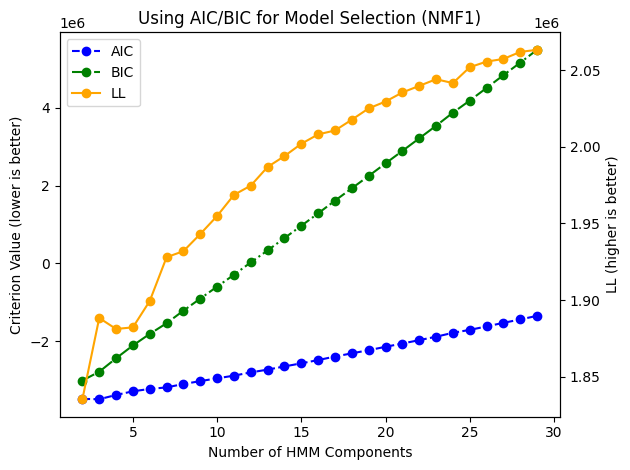

3
2


In [62]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_0)
        score = model.score(x_train_0)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_0))
    bic.append(best_model.bic(x_train_0))
    lls.append(best_model.score(x_train_0))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (NMF1)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

In [ ]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_1)
        score = model.score(x_train_1)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_1))
    bic.append(best_model.bic(x_train_1))
    lls.append(best_model.score(x_train_1))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (NMF1)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

In [ ]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_2)
        score = model.score(x_train_2)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_2))
    bic.append(best_model.bic(x_train_2))
    lls.append(best_model.score(x_train_2))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (NMF1)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

In [ ]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_3)
        score = model.score(x_train_3)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_3))
    bic.append(best_model.bic(x_train_3))
    lls.append(best_model.score(x_train_3))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (NMF1)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

In [ ]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_4)
        score = model.score(x_train_4)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_4))
    bic.append(best_model.bic(x_train_4))
    lls.append(best_model.score(x_train_4))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (NMF1)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

Building the models.

In [64]:
rs = check_random_state(546)
best_ll = None
best_model_0 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_0)
    score = model.score(x_train_0)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_0 = model

Model is not converging.  Current: 1835386.6743909998 is not greater than 1894764.5914118087. Delta is -59377.917020808905
Model is not converging.  Current: 1834373.2560547858 is not greater than 1836194.2698249684. Delta is -1821.013770182617
Model is not converging.  Current: 1817982.2655279464 is not greater than 1818764.2593580955. Delta is -781.993830149062
Model is not converging.  Current: 1835407.147736111 is not greater than 1877097.419465311. Delta is -41690.27172920015


In [65]:
rs = check_random_state(546)
best_ll = None
best_model_1 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_1)
    score = model.score(x_train_1)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_1 = model

Model is not converging.  Current: 1811041.901903455 is not greater than 1811758.0275555945. Delta is -716.1256521395408
Model is not converging.  Current: 1847777.1032576796 is not greater than 1847777.1032577115. Delta is -3.189779818058014e-08


In [66]:
rs = check_random_state(546)
best_ll = None
best_model_2 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_2)
    score = model.score(x_train_2)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_2 = model

Model is not converging.  Current: 1841897.7394864636 is not greater than 1875389.2830890538. Delta is -33491.543602590216
Model is not converging.  Current: 1843426.6207484654 is not greater than 1843793.798554879. Delta is -367.17780641349964
Model is not converging.  Current: 1825702.6826981618 is not greater than 1830409.0176265573. Delta is -4706.334928395459
Model is not converging.  Current: 1860591.72327765 is not greater than 1860591.723277707. Delta is -5.681067705154419e-08
Model is not converging.  Current: 1861789.9838071098 is not greater than 1861789.9838072883. Delta is -1.78581103682518e-07
Model is not converging.  Current: 1861912.719379447 is not greater than 1861912.7193794732. Delta is -2.6309862732887268e-08


In [67]:
rs = check_random_state(546)
best_ll = None
best_model_3 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_3)
    score = model.score(x_train_3)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_3 = model

Model is not converging.  Current: 1849577.8818299198 is not greater than 1850196.3302436373. Delta is -618.4484137175605
Model is not converging.  Current: 1849836.630178999 is not greater than 1892896.596011465. Delta is -43059.96583246603
Model is not converging.  Current: 1834645.6736566427 is not greater than 1837598.9526407104. Delta is -2953.2789840677287
Model is not converging.  Current: 1849530.3828854691 is not greater than 1883099.710636416. Delta is -33569.32775094686
Model is not converging.  Current: 1850092.3136368445 is not greater than 1880338.8093237956. Delta is -30246.495686951093


In [68]:
rs = check_random_state(546)
best_ll = None
best_model_4 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_4)
    score = model.score(x_train_4)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_4 = model

Model is not converging.  Current: 1839025.6113642503 is not greater than 1901272.9988329425. Delta is -62247.38746869215
Model is not converging.  Current: 1839103.6988861389 is not greater than 1840079.9422023322. Delta is -976.2433161933441
Model is not converging.  Current: 1822234.3850006368 is not greater than 1824026.4701776842. Delta is -1792.085177047411
Model is not converging.  Current: 1838823.1448914574 is not greater than 1877169.9337434985. Delta is -38346.78885204112
Model is not converging.  Current: 1856319.6225278943 is not greater than 1856319.6225279598. Delta is -6.542541086673737e-08


Actual classification.

In [69]:
models = [best_model_0, best_model_1, best_model_2, best_model_3, best_model_4]

def HMM_classification(x):
    scores = []
    for model in models:
        scores.append(model.score(x))
    return np.argmax(scores)

preds = []
for i in range(n1):
    preds.append(HMM_classification((x_embed_nmf1[i]).reshape(1,r)))

np.sum(preds == y_train)/n1

np.float64(0.530952380952381)

In [70]:
x_embed_nmf1_val = embed_nmf1(x_val)
x_embed_nmf1_test = embed_nmf1(x_test)

preds = []
for i in range(n2):
    preds.append(HMM_classification((x_embed_nmf1_val[i]).reshape(1,r)))

np.sum(preds == y_val)/n2

np.float64(0.24525316455696203)

In [71]:
preds = []
for i in range(n3):
    preds.append(HMM_classification((x_embed_nmf1_val[i]).reshape(1,r)))

np.sum(preds == y_test)/n3

np.float64(0.2513721185510428)

### NMF2

In [72]:
x_train_0 = (x_embed_nmf2[:1008]).reshape(1008, c)
x_train_1 = (x_embed_nmf2[1008:2016]).reshape(1008, c)
x_train_2 = (x_embed_nmf2[2016:3024]).reshape(1008, c)
x_train_3 = (x_embed_nmf2[3024:4032]).reshape(1008, c)
x_train_4 = (x_embed_nmf2[4032:]).reshape(1008, c)

Choosing the number of possible states.

Model is not converging.  Current: 2199717.97048615 is not greater than 2199717.970487555. Delta is -1.4049001038074493e-06
Model is not converging.  Current: 2245006.1774019194 is not greater than 2245006.1774071287. Delta is -5.209352821111679e-06
Fitting a model with 544074 free scalar parameters with only 468720 data points will result in a degenerate solution.
Fitting a model with 544074 free scalar parameters with only 468720 data points will result in a degenerate solution.
Model is not converging.  Current: 2291209.188471658 is not greater than 2291209.1884716763. Delta is -1.816079020500183e-08
Fitting a model with 652895 free scalar parameters with only 468720 data points will result in a degenerate solution.
Fitting a model with 652895 free scalar parameters with only 468720 data points will result in a degenerate solution.
Fitting a model with 761718 free scalar parameters with only 468720 data points will result in a degenerate solution.
Fitting a model with 761718 free sc

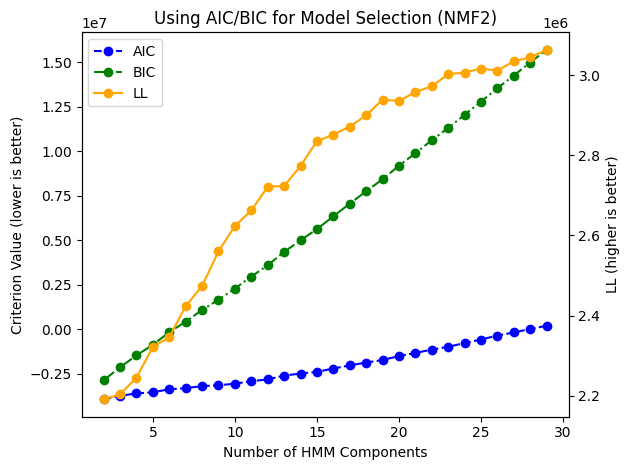

2
2


In [73]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_0)
        score = model.score(x_train_0)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_0))
    bic.append(best_model.bic(x_train_0))
    lls.append(best_model.score(x_train_0))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (NMF2)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

In [ ]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_1)
        score = model.score(x_train_1)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_1))
    bic.append(best_model.bic(x_train_1))
    lls.append(best_model.score(x_train_1))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (NMF2)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

In [ ]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_2)
        score = model.score(x_train_2)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_2))
    bic.append(best_model.bic(x_train_2))
    lls.append(best_model.score(x_train_2))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (NMF2)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

In [ ]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_3)
        score = model.score(x_train_3)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_3))
    bic.append(best_model.bic(x_train_3))
    lls.append(best_model.score(x_train_3))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (NMF2)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

In [ ]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_4)
        score = model.score(x_train_4)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_4))
    bic.append(best_model.bic(x_train_4))
    lls.append(best_model.score(x_train_4))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (NMF2)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

Building the models. 

In [74]:
rs = check_random_state(546)
best_ll = None
best_model_0 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_0)
    score = model.score(x_train_0)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_0 = model

Model is not converging.  Current: 2190796.1683220547 is not greater than 2190796.168714173. Delta is -0.0003921184688806534
Model is not converging.  Current: 2190810.4364886675 is not greater than 2190810.4364906694. Delta is -2.001877874135971e-06
Model is not converging.  Current: 2190322.691035277 is not greater than 2190322.691036793. Delta is -1.5157274901866913e-06


In [75]:
rs = check_random_state(546)
best_ll = None
best_model_1 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_1)
    score = model.score(x_train_1)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_1 = model

Model is not converging.  Current: 2198841.132885831 is not greater than 2198841.1328885728. Delta is -2.7418136596679688e-06
Model is not converging.  Current: 2201166.6488808794 is not greater than 2201166.6488809953. Delta is -1.1594966053962708e-07
Model is not converging.  Current: 2200750.563649235 is not greater than 2200750.5636499613. Delta is -7.264316082000732e-07
Model is not converging.  Current: 2199760.584179811 is not greater than 2199760.584180451. Delta is -6.398186087608337e-07


In [76]:
rs = check_random_state(546)
best_ll = None
best_model_2 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_2)
    score = model.score(x_train_2)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_2 = model

Model is not converging.  Current: 2197443.9194016126 is not greater than 2197443.919406519. Delta is -4.906207323074341e-06
Model is not converging.  Current: 2196183.788764652 is not greater than 2196183.7887677257. Delta is -3.073830157518387e-06


In [77]:
rs = check_random_state(546)
best_ll = None
best_model_3 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_3)
    score = model.score(x_train_3)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_3 = model

Model is not converging.  Current: 2232571.806633252 is not greater than 2232571.8066361174. Delta is -2.8652139008045197e-06


In [78]:
rs = check_random_state(546)
best_ll = None
best_model_4 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_4)
    score = model.score(x_train_4)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_4 = model

Model is not converging.  Current: 2237180.0663372255 is not greater than 2237180.0663390234. Delta is -1.7979182302951813e-06
Model is not converging.  Current: 2234659.583272008 is not greater than 2234659.5832740027. Delta is -1.9944272935390472e-06
Model is not converging.  Current: 2234862.256250372 is not greater than 2234862.256253228. Delta is -2.855900675058365e-06


Actual classification.

In [79]:
models = [best_model_0, best_model_1, best_model_2, best_model_3, best_model_4]

def HMM_classification(x):
    scores = []
    for model in models:
        scores.append(model.score(x))
    return np.argmax(scores)


preds = []
for i in range(n1):
    preds.append(HMM_classification((x_embed_nmf2[i]).reshape(1,c)))

np.sum(preds == y_train)/n1

np.float64(0.8775793650793651)

In [80]:
x_embed_nmf2_val = embed_nmf2(x_val)
x_embed_nmf2_test = embed_nmf2(x_test)

preds = []
for i in range(n2):
    preds.append(HMM_classification((x_embed_nmf2_val[i]).reshape(1,c)))

np.sum(preds == y_val)/n2

np.float64(0.8006329113924051)

In [81]:
preds = []
for i in range(n3):
    preds.append(HMM_classification((x_embed_nmf2_val[i]).reshape(1,c)))

np.sum(preds == y_test)/n3

np.float64(0.7381997804610319)

### NMF3

In [82]:
x_train_0 = (x_embed_nmf3[:1008]).reshape(1008, c+r)
x_train_1 = (x_embed_nmf3[1008:2016]).reshape(1008, c+r)
x_train_2 = (x_embed_nmf3[2016:3024]).reshape(1008, c+r)
x_train_3 = (x_embed_nmf3[3024:4032]).reshape(1008, c+r)
x_train_4 = (x_embed_nmf3[4032:]).reshape(1008, c+r)

Choosing the number of possible states.

In [ ]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_0)
        score = model.score(x_train_0)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_0))
    bic.append(best_model.bic(x_train_0))
    lls.append(best_model.score(x_train_0))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (NMF3)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

In [ ]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_1)
        score = model.score(x_train_1)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_1))
    bic.append(best_model.bic(x_train_1))
    lls.append(best_model.score(x_train_1))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (NMF3)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

In [ ]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_2)
        score = model.score(x_train_2)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_2))
    bic.append(best_model.bic(x_train_2))
    lls.append(best_model.score(x_train_2))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (NMF3)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

In [ ]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_3)
        score = model.score(x_train_3)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_3))
    bic.append(best_model.bic(x_train_3))
    lls.append(best_model.score(x_train_3))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (NMF3)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

In [ ]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_4)
        score = model.score(x_train_4)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_4))
    bic.append(best_model.bic(x_train_4))
    lls.append(best_model.score(x_train_4))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (NMF3)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

Building the models.

In [83]:
rs = check_random_state(546)
best_ll = None
best_model_0 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_0)
    score = model.score(x_train_0)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_0 = model

Model is not converging.  Current: 4081906.747891984 is not greater than 4081906.7478920277. Delta is -4.377216100692749e-08
Model is not converging.  Current: 4085830.1149880337 is not greater than 4085830.114988065. Delta is -3.119930624961853e-08
Model is not converging.  Current: 4086415.851260953 is not greater than 4086415.851261315. Delta is -3.618188202381134e-07
Model is not converging.  Current: 4088463.7832470634 is not greater than 4088463.783247098. Delta is -3.4458935260772705e-08


In [84]:
rs = check_random_state(546)
best_ll = None
best_model_1 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_1)
    score = model.score(x_train_1)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_1 = model

Model is not converging.  Current: 4090415.3682102305 is not greater than 4090415.3682102915. Delta is -6.100162863731384e-08
Model is not converging.  Current: 4087384.452943475 is not greater than 4087384.452943523. Delta is -4.7963112592697144e-08
Model is not converging.  Current: 4089484.94916777 is not greater than 4089484.949167849. Delta is -7.916241884231567e-08
Model is not converging.  Current: 4088890.336350799 is not greater than 4088890.336350856. Delta is -5.681067705154419e-08
Model is not converging.  Current: 4089795.1947573796 is not greater than 4089795.194757438. Delta is -5.820766091346741e-08
Model is not converging.  Current: 4090984.896667637 is not greater than 4090984.8966676556. Delta is -1.862645149230957e-08


In [85]:
rs = check_random_state(546)
best_ll = None
best_model_2 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_2)
    score = model.score(x_train_2)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_2 = model

Model is not converging.  Current: 4095839.734929184 is not greater than 4095839.7349296724. Delta is -4.884786903858185e-07
Model is not converging.  Current: 4032314.781400365 is not greater than 4032314.781400391. Delta is -2.60770320892334e-08


In [86]:
rs = check_random_state(546)
best_ll = None
best_model_3 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_3)
    score = model.score(x_train_3)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_3 = model

Model is not converging.  Current: 4137473.911764385 is not greater than 4137473.911764433. Delta is -4.7963112592697144e-08
Model is not converging.  Current: 4137416.9249043404 is not greater than 4137416.9249043986. Delta is -5.820766091346741e-08


In [87]:
rs = check_random_state(546)
best_ll = None
best_model_4 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_4)
    score = model.score(x_train_4)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_4 = model

Model is not converging.  Current: 4129606.6974150147 is not greater than 4129606.6974153533. Delta is -3.3853575587272644e-07


Actual classification.

In [88]:
models = [best_model_0, best_model_1, best_model_2, best_model_3, best_model_4]

def HMM_classification(x):
    scores = []
    for model in models:
        scores.append(model.score(x))
    return np.argmax(scores)

preds = []
for i in range(n1):
    preds.append(HMM_classification((x_embed_nmf3[i]).reshape(1,c+r)))

np.sum(preds == y_train)/n1

np.float64(0.7226190476190476)

In [89]:
x_embed_nmf3_val = embed_nmf3(x_val)
x_embed_nmf3_test = embed_nmf3(x_test)

preds = []
for i in range(n2):
    preds.append(HMM_classification((x_embed_nmf3_val[i]).reshape(1,c+r)))

np.sum(preds == y_val)/n2

np.float64(0.6497890295358649)

In [90]:
preds = []
for i in range(n3):
    preds.append(HMM_classification((x_embed_nmf3_val[i]).reshape(1,c+r)))

np.sum(preds == y_test)/n3

np.float64(0.6086717892425906)

### Autoencoder

In [104]:
x_train_0 = (x_embed_ae[:1008]).reshape(1008, r)
x_train_1 = (x_embed_ae[1008:2016]).reshape(1008, r)
x_train_2 = (x_embed_ae[2016:3024]).reshape(1008, r)
x_train_3 = (x_embed_ae[3024:4032]).reshape(1008, r)
x_train_4 = (x_embed_ae[4032:]).reshape(1008, r)

Choosing the number of possible states.

Model is not converging.  Current: 1722599.4220197585 is not greater than 1722599.4220200044. Delta is -2.4586915969848633e-07
Model is not converging.  Current: 1761202.6263047915 is not greater than 1761202.6263048274. Delta is -3.585591912269592e-08
Model is not converging.  Current: 1755378.204453672 is not greater than 1755378.204459791. Delta is -6.119022145867348e-06
Fitting a model with 335306 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 335306 free scalar parameters with only 310464 data points will result in a degenerate solution.
Model is not converging.  Current: 1796209.1665700714 is not greater than 1796209.1665700944. Delta is -2.3050233721733093e-08
Fitting a model with 383215 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 383215 free scalar parameters with only 310464 data points will result in a degenerate solution.
Fitting a model with 431

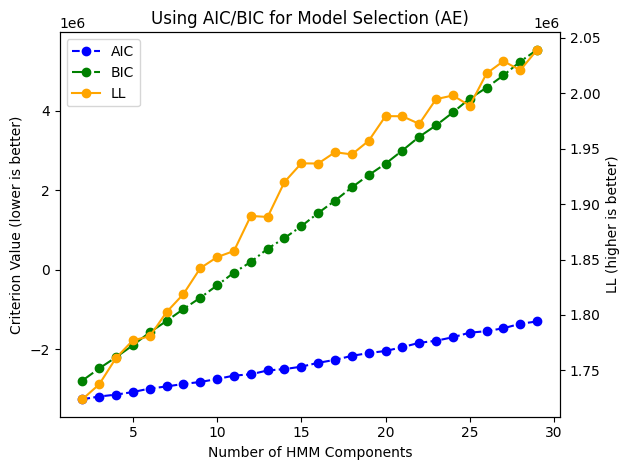

2
2


In [105]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_0)
        score = model.score(x_train_0)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_0))
    bic.append(best_model.bic(x_train_0))
    lls.append(best_model.score(x_train_0))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (AE)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

In [ ]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_1)
        score = model.score(x_train_1)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_1))
    bic.append(best_model.bic(x_train_1))
    lls.append(best_model.score(x_train_1))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (AE)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

In [ ]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_2)
        score = model.score(x_train_2)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_2))
    bic.append(best_model.bic(x_train_2))
    lls.append(best_model.score(x_train_2))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (AE)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

In [ ]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_3)
        score = model.score(x_train_3)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_3))
    bic.append(best_model.bic(x_train_3))
    lls.append(best_model.score(x_train_3))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (AE)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

In [ ]:
rs = check_random_state(546)

aic = []
bic = []
lls = []
for n in range(2, 30):
    best_ll = None
    best_model = None
    for i in range(2):
        model = GaussianHMM(n, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
        model.fit(x_train_4)
        score = model.score(x_train_4)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = model
    aic.append(best_model.aic(x_train_4))
    bic.append(best_model.bic(x_train_4))
    lls.append(best_model.score(x_train_4))

fig, ax = plt.subplots()
ln1 = ax.plot(np.arange(2, 30), aic, label="AIC", color="blue", marker="o", ls='--')
ln2 = ax.plot(np.arange(2, 30), bic, label="BIC", color="green", marker="o", ls='-.')
ax2 = ax.twinx()
ln3 = ax2.plot(np.arange(2, 30), lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection (AE)")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

print(np.argmin(np.array(aic))+2)
print(np.argmin(np.array(bic))+2)

Building the models.

In [106]:
rs = check_random_state(546)
best_ll = None
best_model_0 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_0)
    score = model.score(x_train_0)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_0 = model

Model is not converging.  Current: 1723883.1441409187 is not greater than 1723883.14414134. Delta is -4.2119063436985016e-07
Model is not converging.  Current: 1719300.1410526307 is not greater than 1719300.1417599393. Delta is -0.00070730852894485
Model is not converging.  Current: 1729680.3037678942 is not greater than 1729680.303767946. Delta is -5.192123353481293e-08
Model is not converging.  Current: 1724833.1152284173 is not greater than 1724833.1152316914. Delta is -3.2740645110607147e-06
Model is not converging.  Current: 1724463.95631376 is not greater than 1724463.9564332075. Delta is -0.00011944747529923916


In [107]:
rs = check_random_state(546)
best_ll = None
best_model_1 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_1)
    score = model.score(x_train_1)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_1 = model

Model is not converging.  Current: 1724042.6997249362 is not greater than 1724042.6997249592. Delta is -2.3050233721733093e-08
Model is not converging.  Current: 1725046.6790712357 is not greater than 1725046.679075108. Delta is -3.872206434607506e-06


In [108]:
rs = check_random_state(546)
best_ll = None
best_model_2 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_2)
    score = model.score(x_train_2)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_2 = model

Model is not converging.  Current: 1727262.3765425957 is not greater than 1727262.3765474502. Delta is -4.854518920183182e-06
Model is not converging.  Current: 1729953.7565146293 is not greater than 1729953.7565146624. Delta is -3.306195139884949e-08


In [109]:
rs = check_random_state(546)
best_ll = None
best_model_3 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_3)
    score = model.score(x_train_3)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_3 = model

Model is not converging.  Current: 1739657.0770077351 is not greater than 1739657.0770221804. Delta is -1.444527879357338e-05
Model is not converging.  Current: 1738462.178272836 is not greater than 1738462.17920826. Delta is -0.0009354241192340851
Model is not converging.  Current: 1740563.1827562253 is not greater than 1740563.1829452543. Delta is -0.0001890289131551981
Model is not converging.  Current: 1740179.4285253622 is not greater than 1740179.4285528671. Delta is -2.750498242676258e-05
Model is not converging.  Current: 1741393.492403612 is not greater than 1741393.4924037436. Delta is -1.3154931366443634e-07
Model is not converging.  Current: 1740824.644226626 is not greater than 1740824.6442299867. Delta is -3.3606775104999542e-06


In [110]:
rs = check_random_state(546)
best_ll = None
best_model_4 = None

for i in range(10):
    model = GaussianHMM(2, covariance_type='full', n_iter=200, tol=1e-4, random_state=rs, verbose=False)
    model.fit(x_train_4)
    score = model.score(x_train_4)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model_4 = model

Model is not converging.  Current: 1745827.5011047851 is not greater than 1745827.5011054403. Delta is -6.551854312419891e-07
Model is not converging.  Current: 1751334.0712846396 is not greater than 1751334.071286288. Delta is -1.648440957069397e-06
Model is not converging.  Current: 1751108.8220953194 is not greater than 1751108.8220983087. Delta is -2.989312633872032e-06
Model is not converging.  Current: 1751272.008400289 is not greater than 1751272.008404906. Delta is -4.616798833012581e-06
Model is not converging.  Current: 1751358.2950974582 is not greater than 1751358.2953388407. Delta is -0.00024138251319527626


Actual classification.

In [112]:
models = [best_model_0, best_model_1, best_model_2, best_model_3, best_model_4]

def HMM_classification(x):
    scores = []
    for model in models:
        scores.append(model.score(x))
    return np.argmax(scores)

preds = []
for i in range(n1):
    preds.append(HMM_classification((x_embed_ae[i]).reshape(1,r)))

np.sum(preds == y_train)/n1

np.float64(0.45674603174603173)

In [114]:
x_embed_ae_val = encoder(x_val.reshape(n2, r*c))
x_embed_ae_test = encoder(x_test.reshape(n3, r*c))

preds = []
for i in range(n2):
    preds.append(HMM_classification((x_embed_ae_val[i]).reshape(1,r)))

np.sum(preds == y_val)/n2

np.float64(0.33544303797468356)

In [115]:
preds = []
for i in range(n3):
    preds.append(HMM_classification((x_embed_ae_val[i]).reshape(1,r)))

np.sum(preds == y_test)/n3

np.float64(0.3150384193194292)

## Convolutional Networks

In this final part, we forego all of our previous embeddings and instead build a convolutional neural network, which finds a lower dimensional representation for the data on its own.

In [5]:
# we need to use one hot encoding:
y_train_one_hot_enc = to_categorical(y_train)
y_val_one_hot_enc = to_categorical(y_val)
y_test_one_hot_enc = to_categorical(y_test)

In [6]:
#lr = random.uniform(0.001, 0.15)
#m = random.uniform(0.85, 0.95)
#d = random.uniform(0.001, 0.15)
model = Sequential()
model.add(Conv2D(4, 5, input_shape=(r, c, 1)))
model.add(MaxPooling2D(pool_size=5))
model.add(Conv2D(8, 5))
model.add(MaxPooling2D(pool_size=5))
model.add(Flatten())
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5000, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, weight_decay=0.01), 
              metrics=['accuracy'])
start_time = time.time()
model.fit(x_train, y_train_one_hot_enc, epochs=20, batch_size=100, validation_data=(x_val, y_val_one_hot_enc))
print("\t\t took %s seconds " % round((time.time() - start_time),5))
print(model.evaluate(x_val, y_val_one_hot_enc))
print(model.evaluate(x_test, y_test_one_hot_enc))

Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.3301 - loss: 1.5775 - val_accuracy: 0.3576 - val_loss: 1.5545
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5185 - loss: 1.3341 - val_accuracy: 0.6561 - val_loss: 0.9132
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7336 - loss: 0.7071 - val_accuracy: 0.7664 - val_loss: 0.6006
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.7929 - loss: 0.5590 - val_accuracy: 0.7669 - val_loss: 0.6016
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8321 - loss: 0.4565 - val_accuracy: 0.7801 - val_loss: 0.6128
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8762 - loss: 0.3570 - val_accuracy: 0.8349 - val_loss: 0.5005
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8993 - loss: 0.2850 - val_accuracy: 0.8122 - val_loss: 0.5602
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9225 - loss: 0.2156 - val_accuracy: 0.8265 - val_loss: